In [1]:
#NOTES
#consider an ensemble of (catboost1 +catboost2 +catboost3 +XGBoost1 + XGBoost2)
#handle outliers
#feature importance and shaply
#custom scorer


import pandas as pd
import numpy as np
import os

#change working directory
#os.chdir("C:/Users/wagne/OneDrive - Washington State University (email.wsu.edu)/Application Materials/Grad to Professional/Applications/Zillow")

#set pandas defaults for number of rows and columns to display
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)

#read in data
dfTrain = pd.read_csv("Data Science ZExercise_TRAINING_CONFIDENTIAL1.csv", parse_dates=['TransDate'])
dfTest = pd.read_csv("Data Science ZExercise_TEST_CONFIDENTIAL2.csv", parse_dates=['TransDate'])

dfTrain

,PropertyID,SaleDollarCnt,TransDate,censusblockgroup,ZoneCodeCounty,Usecode,BedroomCnt,BathroomCnt,FinishedSquareFeet,GarageSquareFeet,LotSizeSquareFeet,StoryCnt,BuiltYear,ViewType,Latitude,Longitude,BGMedHomeValue,BGMedRent,BGMedYearBuilt,BGPctOwn,BGPctVacant,BGMedIncome,BGPctKids,BGMedAge
0,48648941,285000.0,2015-05-23,5.300000e+11,R7,9,4.0,2.00,1900.0,480.0,7482,1.0,1965.0,NaN,47321389,-122213716,107800.0,844.0,1975.0,0.6685,0.0780,42854,0.1924,48.6
1,48648982,309950.0,2015-08-22,5.300000e+11,R8P,9,3.0,2.00,2170.0,320.0,14208,1.0,1953.0,79.0,47482082,-122244269,181500.0,925.0,1969.0,0.5753,0.0192,54013,0.3718,42.6
2,48649024,476000.0,2015-08-27,5.300000e+11,SF 7200,9,4.0,1.00,2150.0,590.0,6500,1.0,1955.0,NaN,47561383,-122308083,344300.0,733.0,1946.0,0.6331,0.0000,56782,0.3207,40.7
3,48649040,324950.0,2015-07-01,5.300000e+11,R1,9,4.0,2.25,2560.0,NaN,15767,1.0,1962.0,79.0,47387929,-122279389,284200.0,900.0,1977.0,0.5456,0.0573,44200,0.3359,40.0
4,48649057,325000.0,2015-06-20,5.300000e+11,LDR,9,4.0,1.75,1720.0,NaN,8620,2.0,1948.0,78.0,47477068,-122263852,290100.0,802.0,1972.0,0.4267,0.0551,65282,0.1633,44.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11583,124398886,489990.0,2015-09-19,5.300000e+11,MU12,9,3.0,2.00,2550.0,300.0,2508,2.0,2015.0,NaN,47733216,-121980040,346800.0,1313.0,1989.0,0.7856,0.0000,100362,0.4426,34.1
11584,124424607,515000.0,2015-09-24,5.300000e+11,R8,9,4.0,2.25,2764.0,620.0,4851,2.0,2015.0,NaN,47455220,-122197972,194600.0,1069.0,1961.0,0.7270,0.0000,67500,0.4724,38.1
11585,124424980,569900.0,2015-09-02,5.300000e+11,R8,9,3.0,2.75,2860.0,630.0,4526,2.0,2015.0,NaN,47502826,-122151070,319200.0,696.0,1972.0,0.7703,0.0000,108636,0.3475,34.4
11586,124435328,880000.0,2015-09-30,5.300000e+11,SF 7200,9,4.0,2.75,2850.0,520.0,7200,2.0,2015.0,NaN,47707734,-122312365,402100.0,908.0,1953.0,0.6156,0.0000,84375,0.2121,38.6


In [2]:
#looks like censusblockgroup was rounded in the csv file, censusblockgroup = 5.300000e+11 for each obs
#recover FIPS using FCC Geocode API
# the API takes about 40 mins per dataset, to save time I simply import and merge the saved FIPS info

dfLatLngTrain = pd.read_csv("latlongZillowTrain.csv")
dfTrain = dfTrain.merge(dfLatLngTrain, on='PropertyID')

dfLatLngTest = pd.read_csv("latlongZillowTest.csv")
dfTest = dfTest.merge(dfLatLngTest, on='PropertyID')

# # requests from API  (inspired by https://github.com/jdeferio/FCC-Geocode)

# import requests

# # Read the data to a Pandas DataFrame
# data = pd.read_csv("Data Science ZExercise_TEST_CONFIDENTIAL2.csv")

# # Form a list of Lat/Long for geocoding:
# latitudes = (data["Latitude"]/1000000).tolist()
# longitudes = (data["Longitude"]/1000000).tolist()
# zid = data['PropertyID'].tolist()

# #get function
# def get_fcc_results(latitude,longitude,i):
#     """
#     Get geocode results from FCC API.
#     Note, that in the case of multiple FCC geocode results, this function returns details of the FIRST result.
#     @param return_full_response: Boolean to indicate if you'd like to return the full response from google. This
#                     is useful if you'd like additional location details for storage or parsing later.
#     """
#     # Set up your Geocoding url
#     geocode_url = "https://geo.fcc.gov/api/census/area?lat={}&lon={}&format=json".format(latitude,longitude)


#    # Ping FCC for the reuslts:
#     results = requests.get(geocode_url)
#     # Results will be in JSON format - convert to dict using requests functionality
#     results = results.json()

#     # if there's no results or an error, return empty results.
#     if len(results['results']) == 0:
#         output = {
#             "FIPS" : None
#         }
#     else:
#         output = {
#             "FIPS": results['results'][0]['block_fips']
#         }

#     # Append some other details:
#     output['latitudes'] = latitude
#     output['longitudes'] = longitude

#     # output['number_of_results'] = len(results['results'])
#     output['PropertyID'] = zid[i]

#     return output

# # Create a list to hold results
# results = []
# i=0
# # Go through each lat-long in turn
# for latitude, longitude in zip(latitudes, longitudes):
#     geocode_result = get_fcc_results(latitude,longitude, i)
#     results.append(geocode_result)
#     i+=1

# pd.DataFrame(results).to_csv('latlongZillowTest.csv')

In [3]:
#clean up the data and add some new features

def dataPrep(df):
    #create a FIPS tract code by dropping ones digit from FIPS block code
    tractFIPS = []
    FIPS = np.array(df['FIPS']).astype(str)
    for i in range(len(FIPS)):
        tractFIPS.append(FIPS[i][0:len(FIPS[i])-1])
    df['tractFIPS'] = np.array(tractFIPS).astype(str)
    df['FIPS'] = np.array(df['FIPS']).astype(str)

    #change dates into vars
    df['TransDayOfYear'] = df['TransDate'].dt.dayofyear
    df['TransDayOfMonth'] = df['TransDate'].dt.day
    df['TransDayOfWeek'] = df['TransDate'].dt.dayofweek
    df['TransMonth'] = df['TransDate'].dt.month
    df['TransQuarter'] = df['TransDate'].dt.quarter
    df['TransWeek'] = df['TransDate'].dt.week
    
    #some time trend vars
    df['day'] = df['TransDayOfYear']
    df['daysq'] = np.power(df['TransDayOfYear'],2)
    df['daycu'] = np.power(df['TransDayOfYear'],3)
    df['week'] = df['TransWeek']
    df['weeksq'] = np.power(df['TransWeek'],2)
    df['weekcu'] = np.power(df['TransWeek'],3)
    
    #constant for linear regression
    df['const'] = 1

    #use intution about the housing market to generate new features
    df['bedBathRatio'] = df['BedroomCnt']/df['BathroomCnt'] 
    df['yardSqft'] = df['LotSizeSquareFeet'] - df['FinishedSquareFeet'] #should subtract garage too
    df['age'] = 2015 - df['BuiltYear']
    df['sqftPerFloor'] = df['FinishedSquareFeet']/df['StoryCnt']
    df['sqftPerBed'] = df['FinishedSquareFeet']/df['BedroomCnt']
    df['sqftPerBath'] = df['FinishedSquareFeet']/df['BathroomCnt']
    df['new'] = (df['age']==0).astype(int)
    df['noVacant'] = (df['BGPctVacant']==0).astype(int)
    df['richRent'] = (df['BGMedRent']>2000).astype(int)
    df['richHome'] = (df['BGMedHomeValue']>1000000).astype(int)
    for var in ['FinishedSquareFeet','GarageSquareFeet','LotSizeSquareFeet','sqftPerFloor','sqftPerBed','sqftPerBath']:
        df['log'+var] = np.log(df[var])

    #dummy for has garage
    df['HasGarage'] = (np.isnan(df['GarageSquareFeet'])).astype(int)

    # drop some useless vars
    df = df.drop(['latitudes', 'longitudes', 'Unnamed: 0', 'censusblockgroup', 'Usecode', 'TransDate'], axis=1)

    #fix missing values
    df.fillna(-999, inplace=True)

    #convert to int for cat_features
    df['ViewType'] = df['ViewType'].astype(int)
        
    y = df['SaleDollarCnt']
    x = df.loc[:, 'ZoneCodeCounty':]

    return x, y


xTrain = dataPrep(dfTrain)[0]
yTrain = dataPrep(dfTrain)[1]
yLogTrain = np.log(yTrain)

xTest = dataPrep(dfTest)[0]
#yTest = dataPrep(dfTest)[1]
#yLogTest = np.log(yTest)


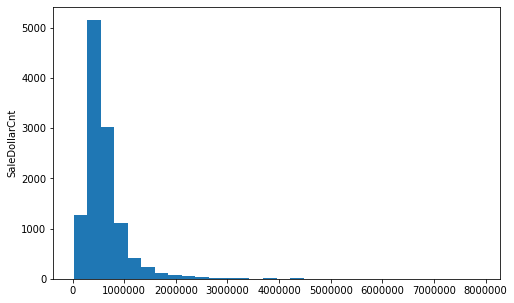

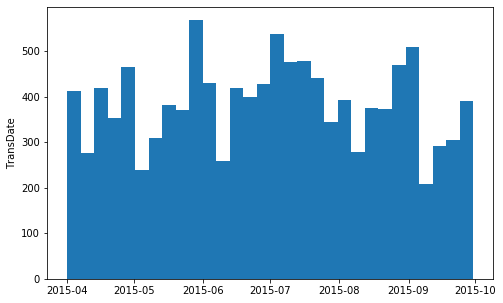

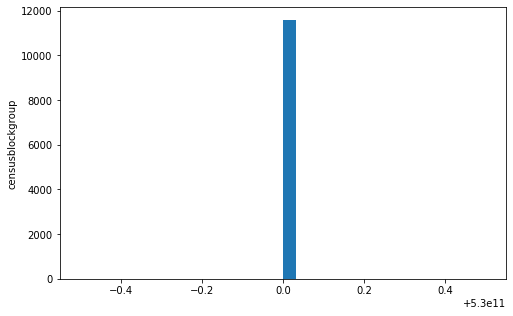

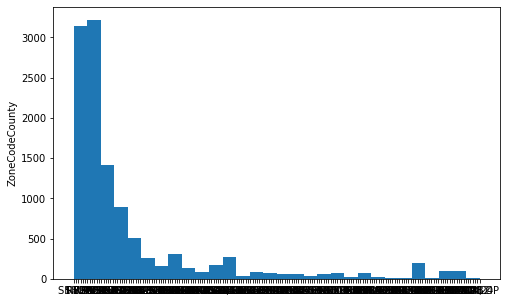

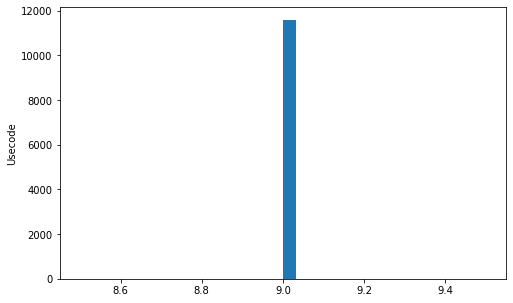

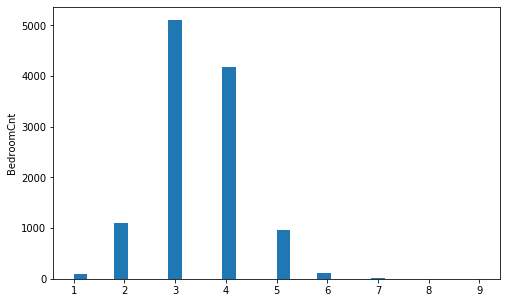

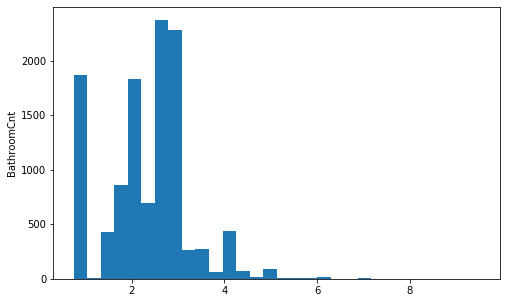

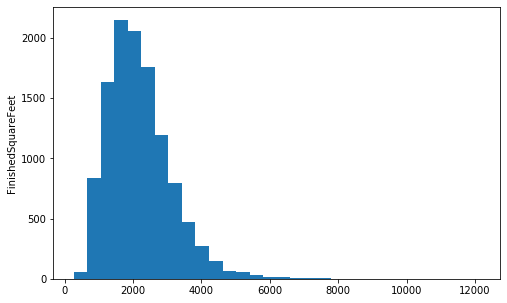

invalid value encountered in greater_equal
invalid value encountered in less_equal


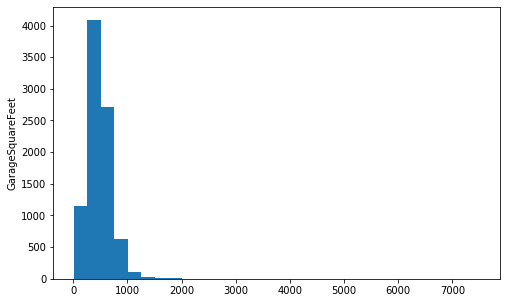

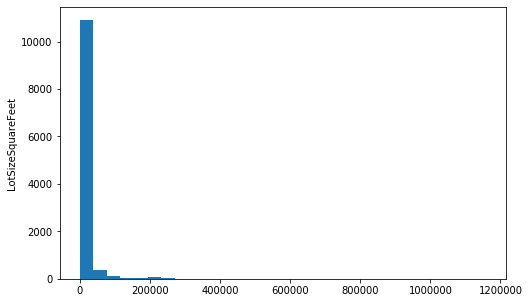

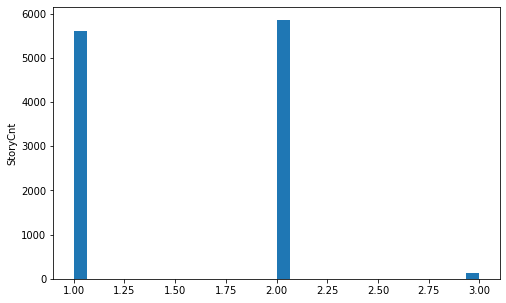

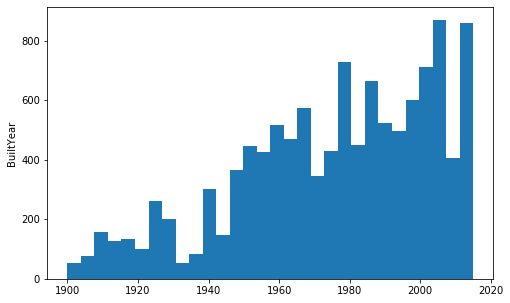

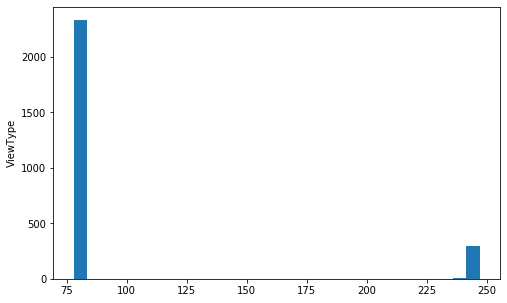

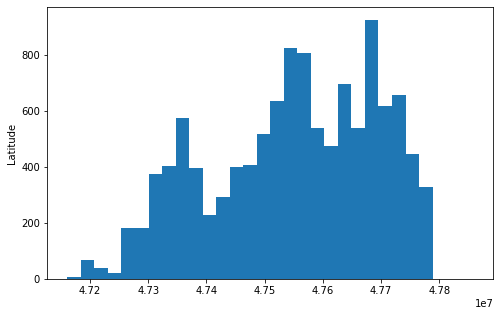

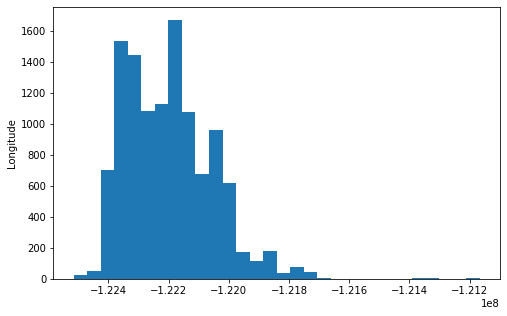

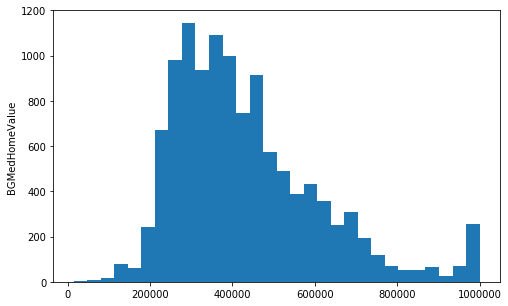

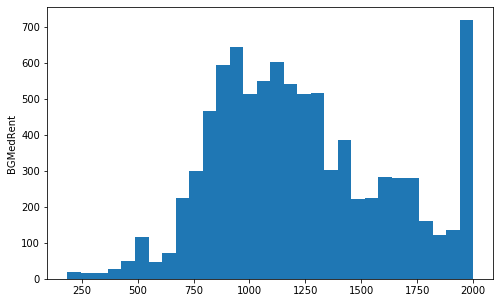

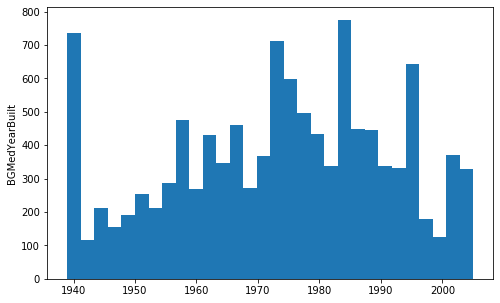

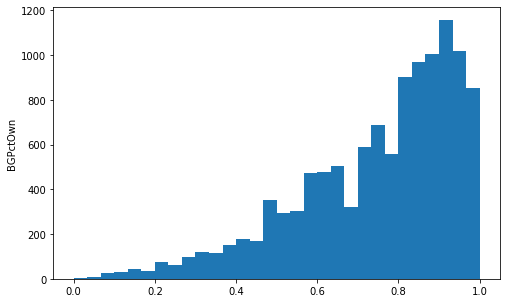

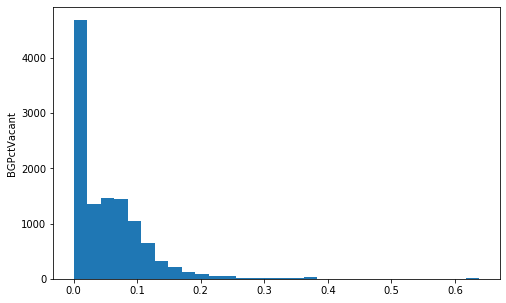

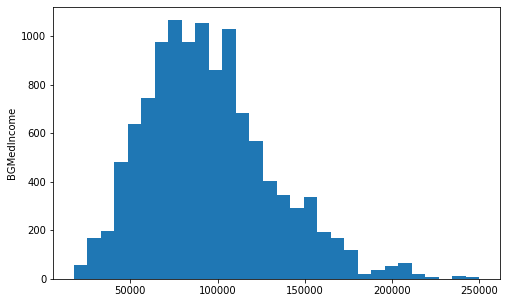

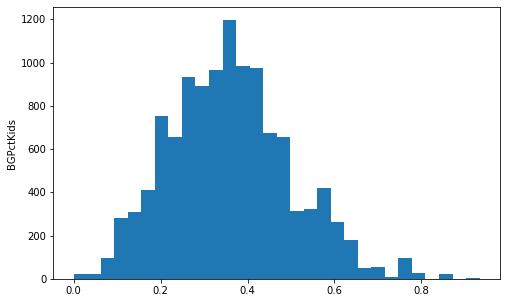

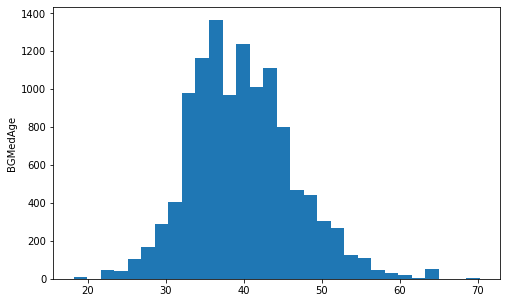

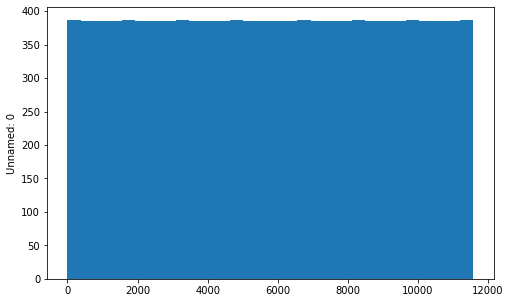

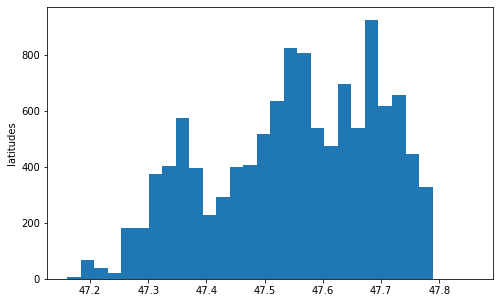

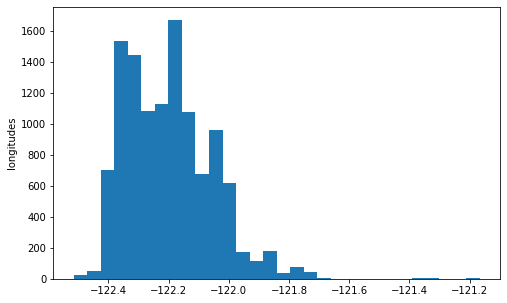

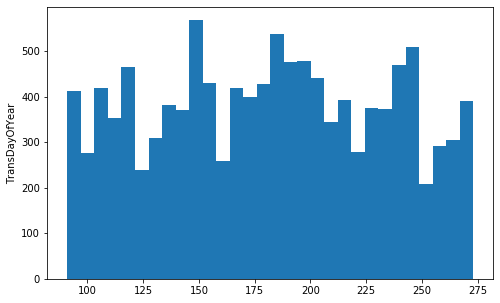

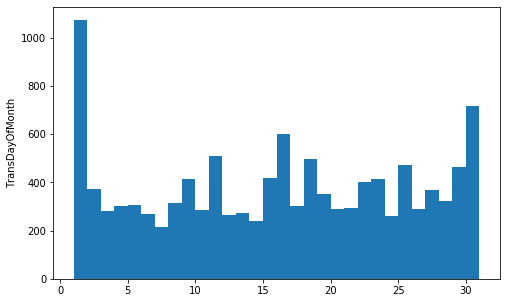

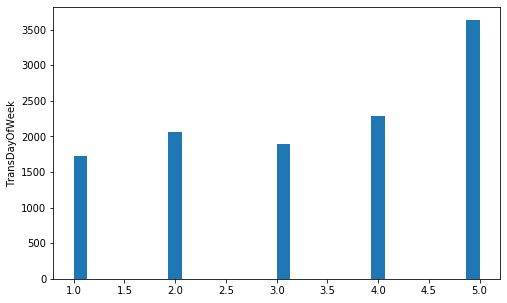

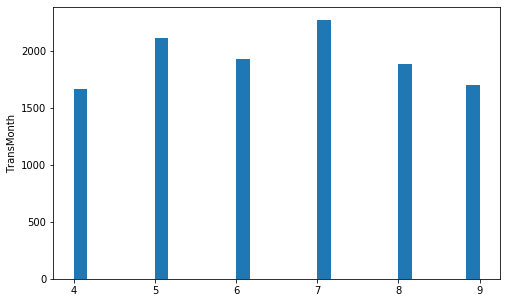

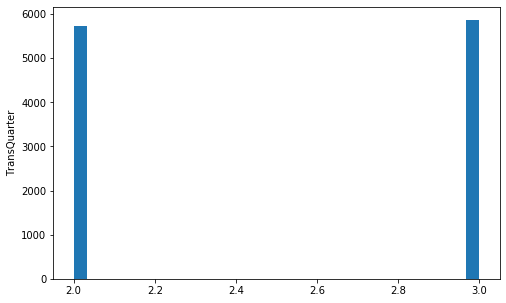

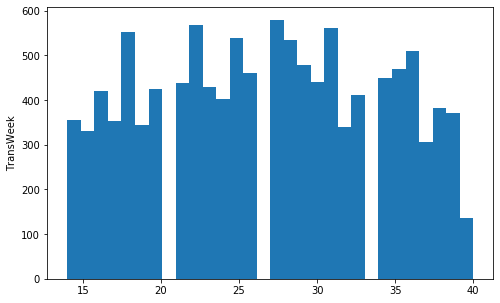

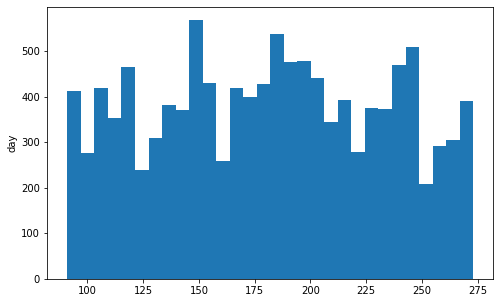

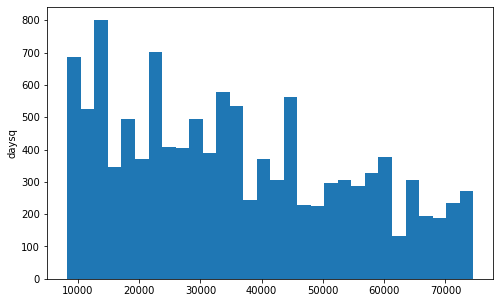

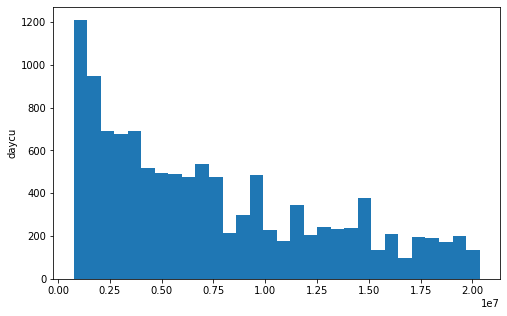

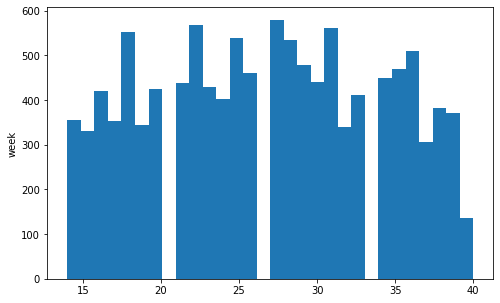

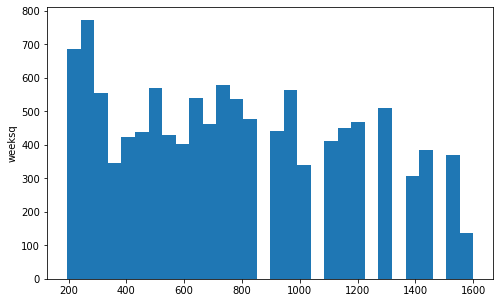

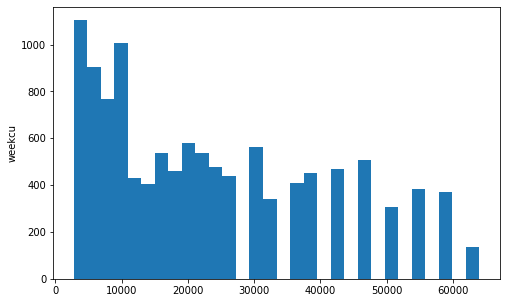

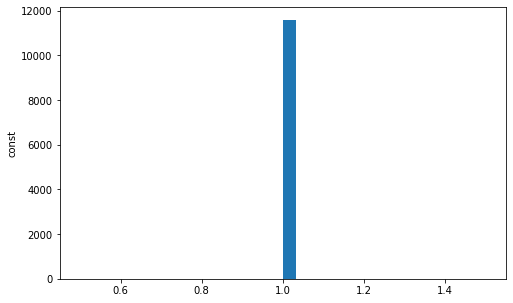

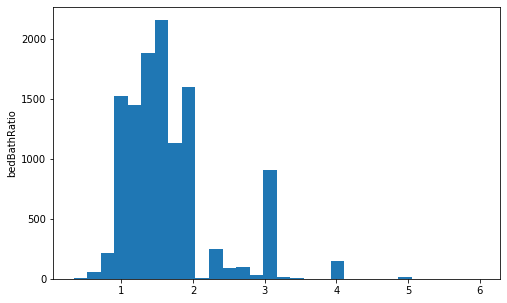

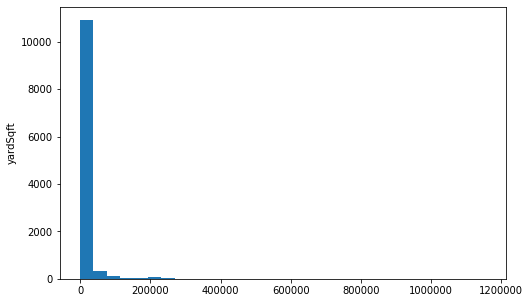

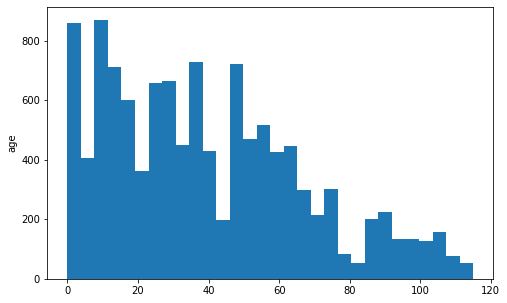

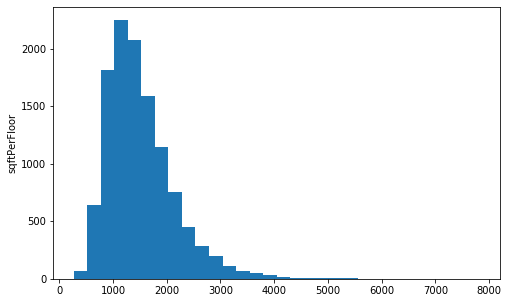

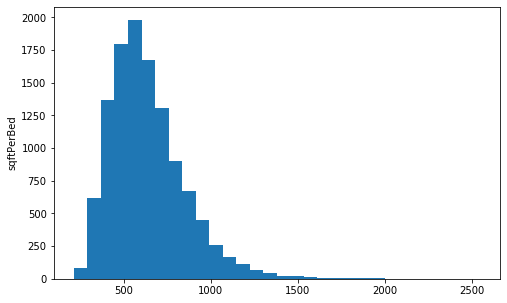

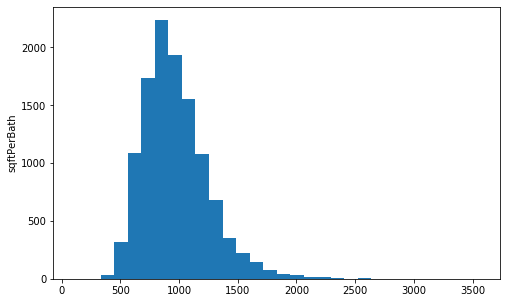

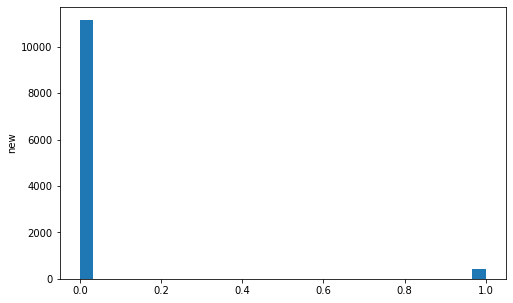

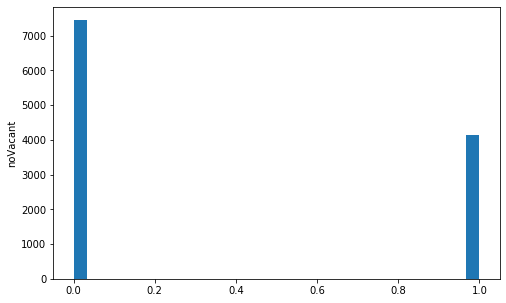

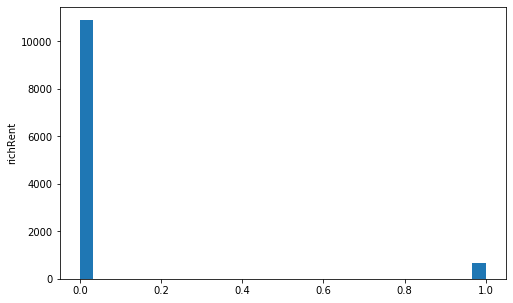

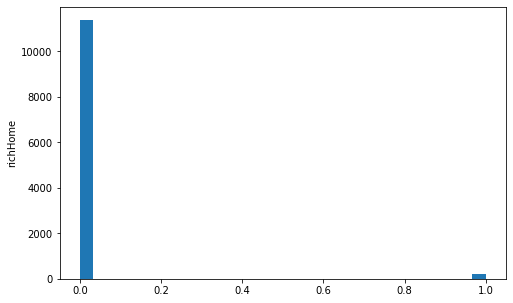

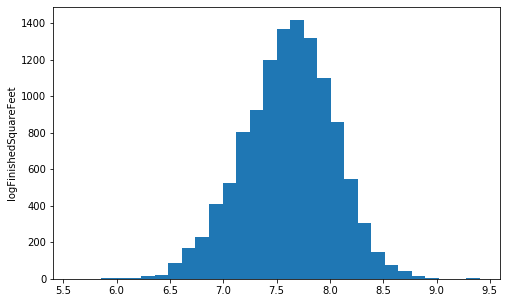

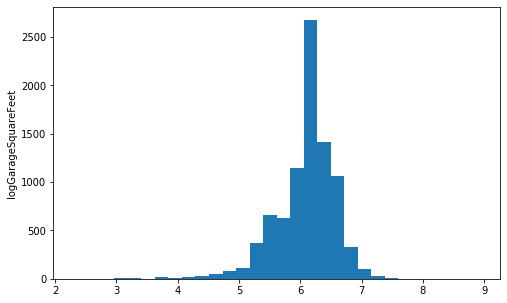

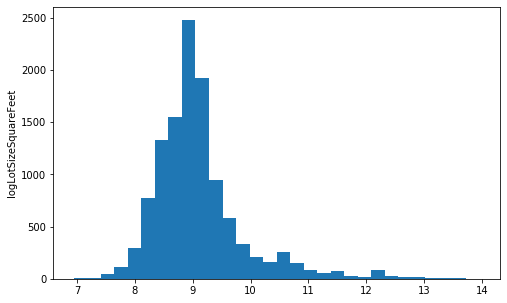

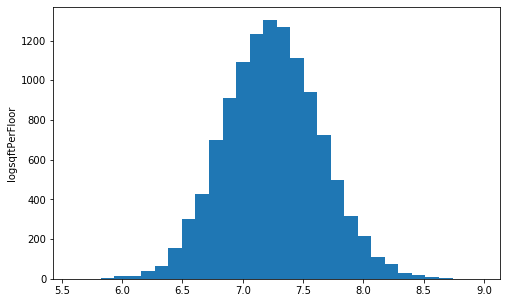

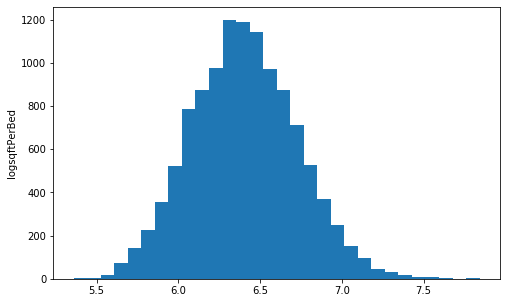

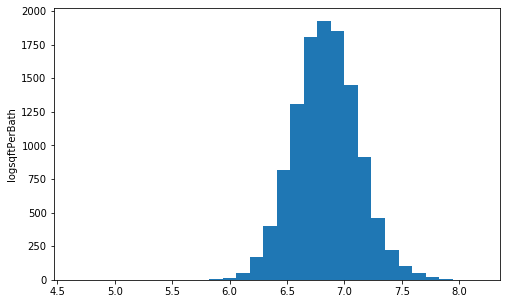

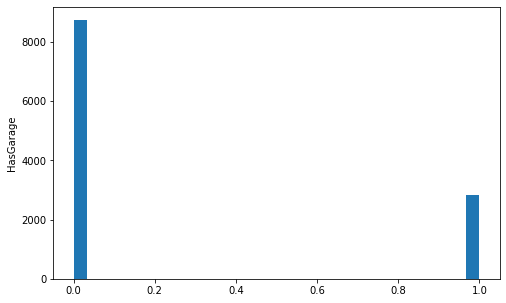

In [25]:
# #exploratory analysis
import matplotlib.pyplot as plt
for var in dfTrain.drop(['FIPS','tractFIPS','PropertyID'],axis=1):
    fig, ax = plt.subplots(figsize=(8,5))
    ax.hist(dfTrain[var], bins=30)
    ax.set_ylabel(var)
    plt.show()

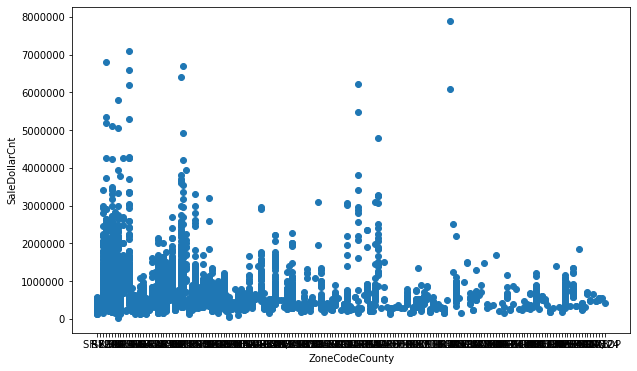

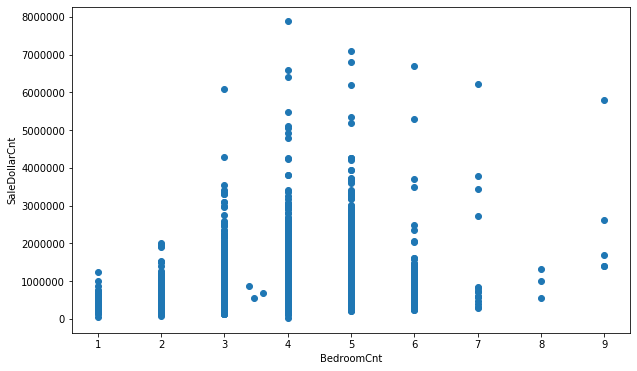

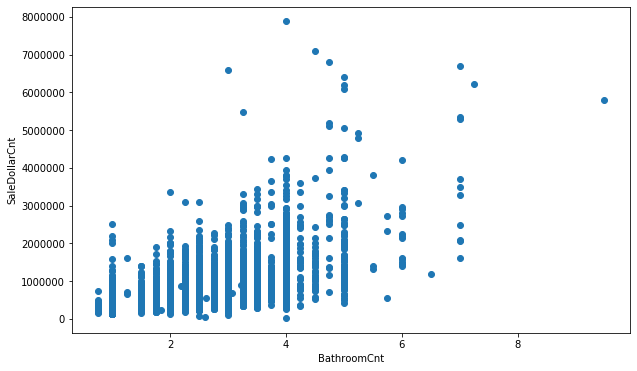

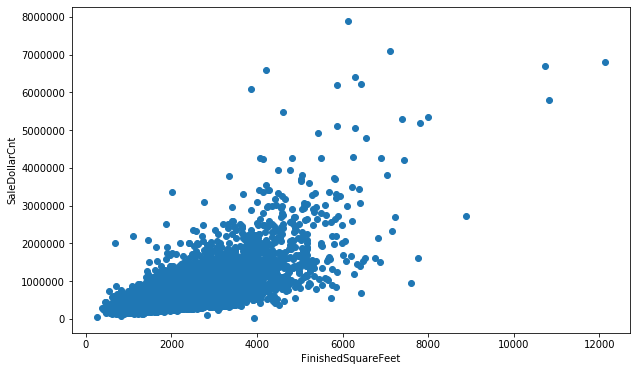

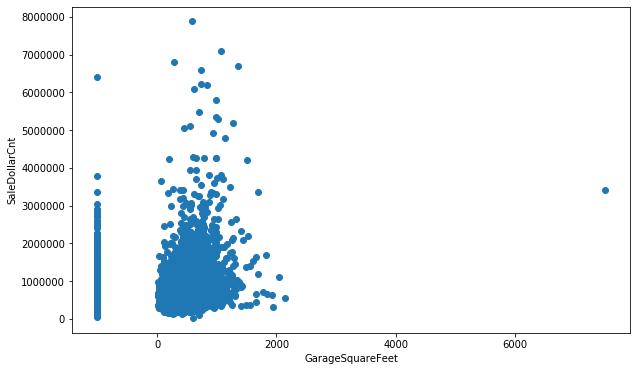

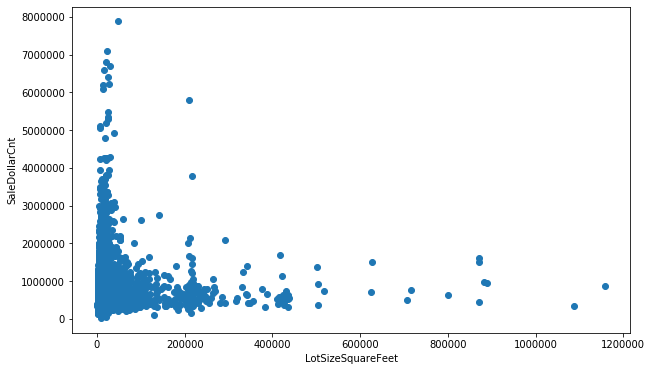

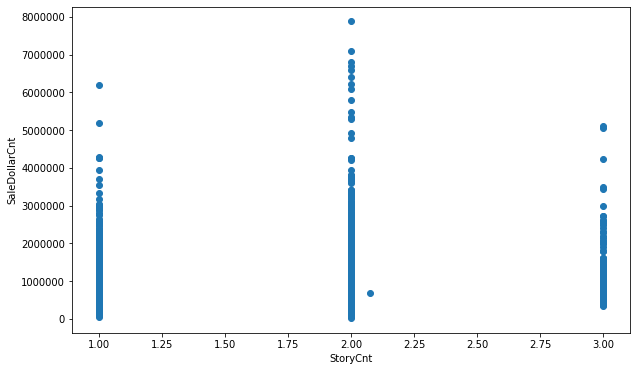

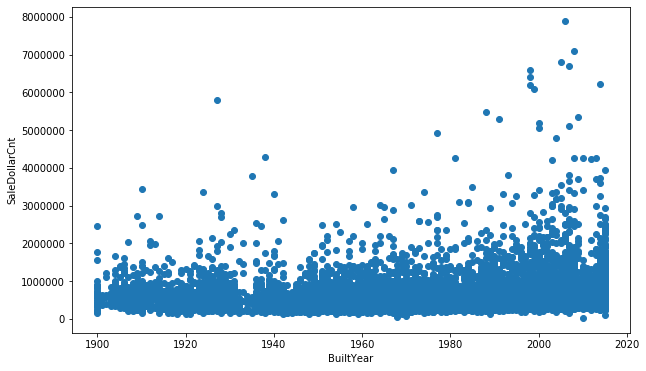

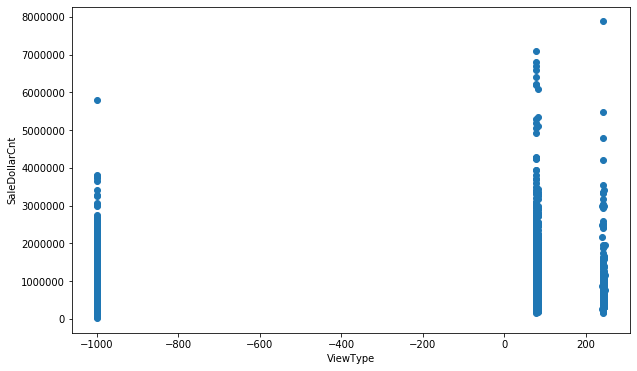

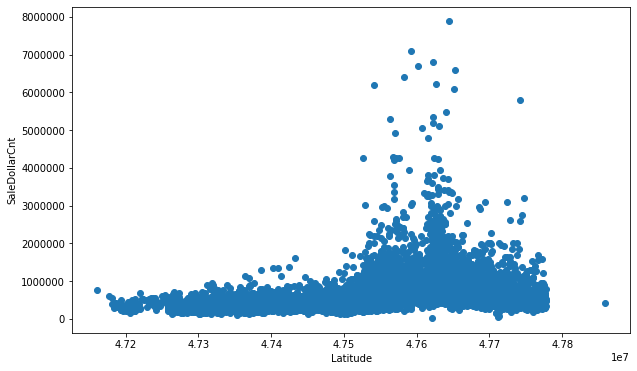

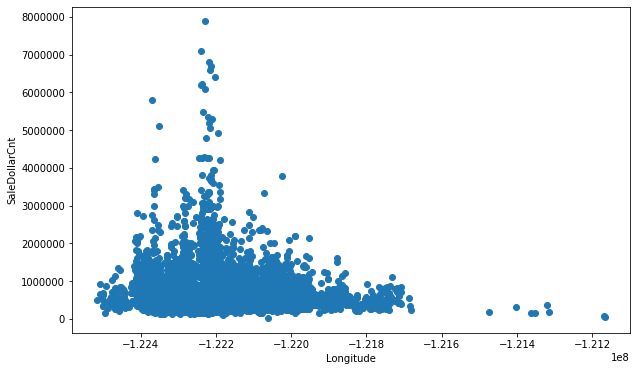

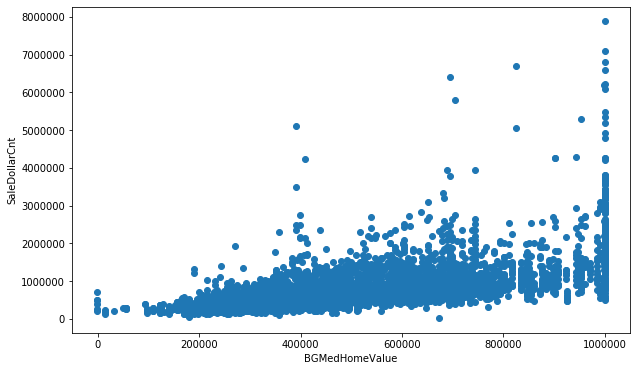

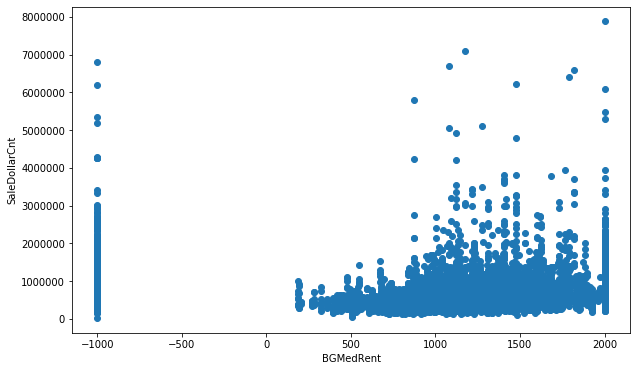

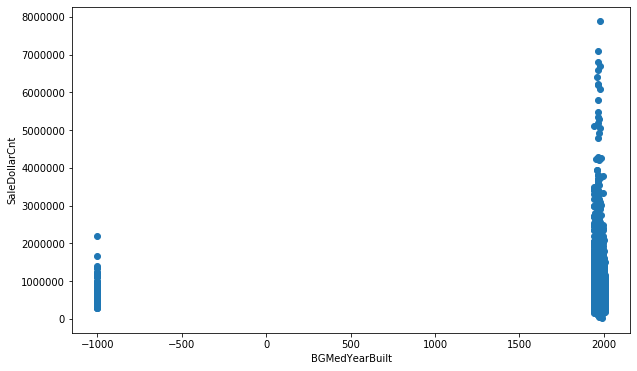

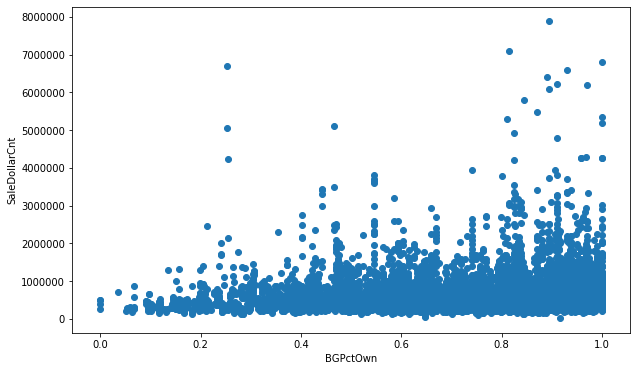

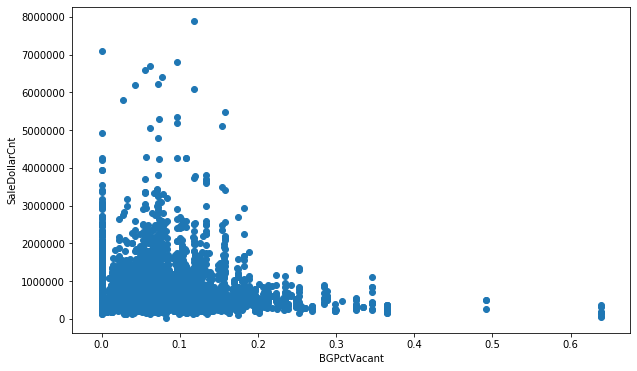

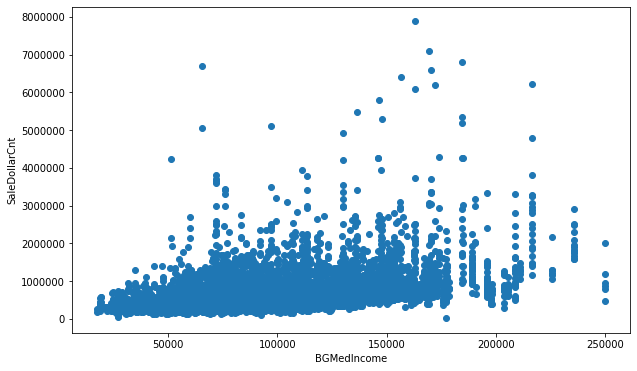

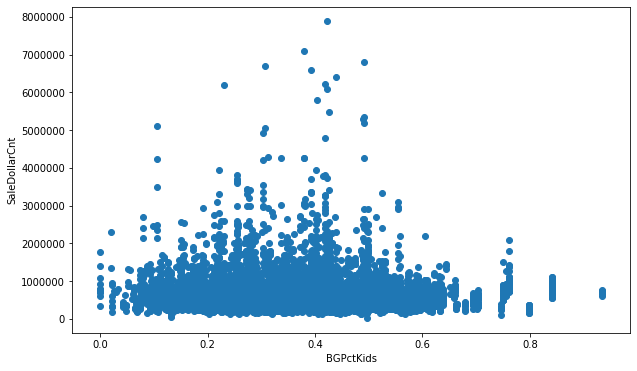

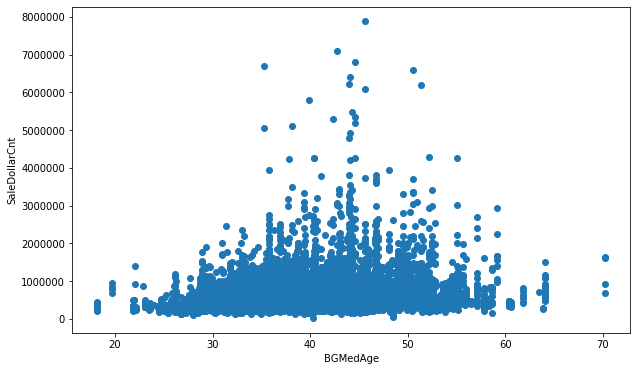

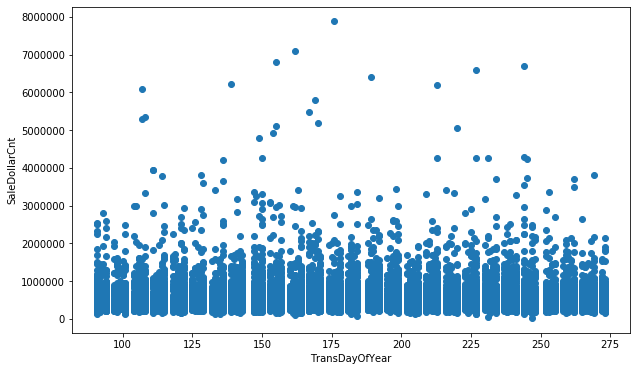

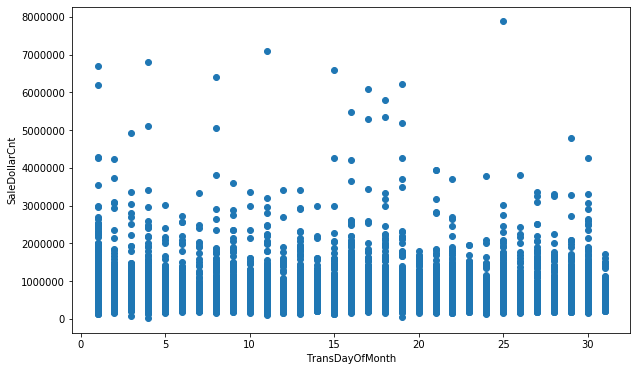

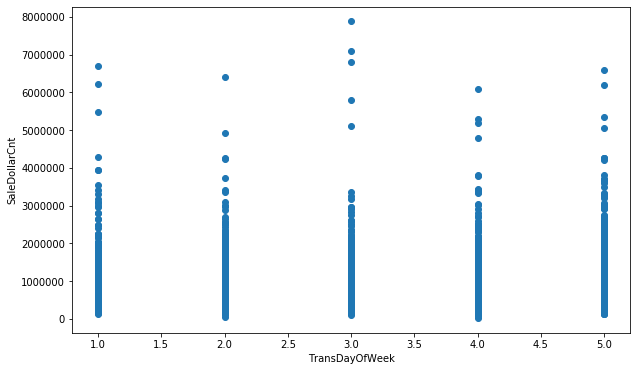

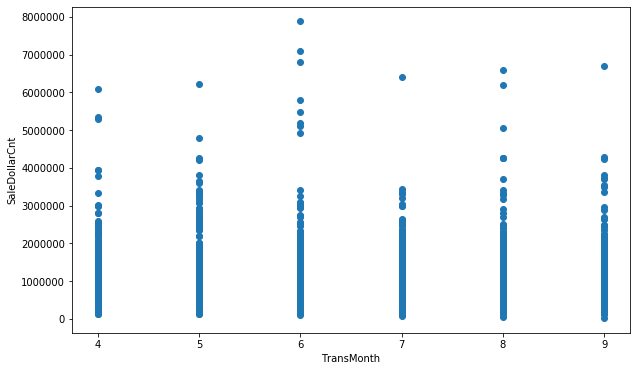

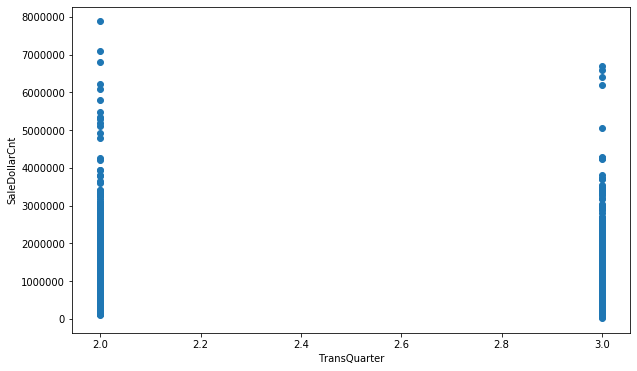

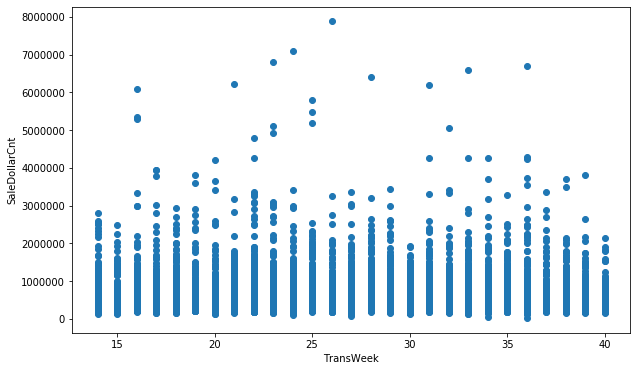

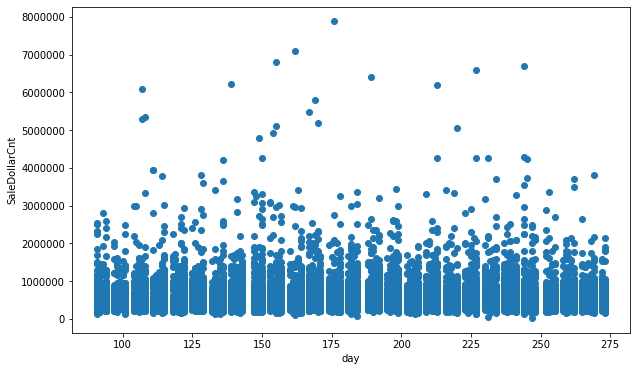

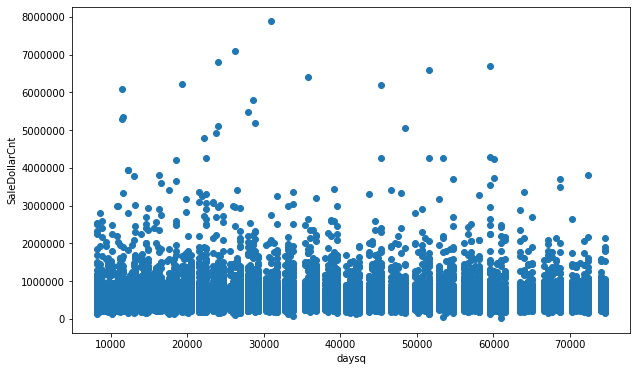

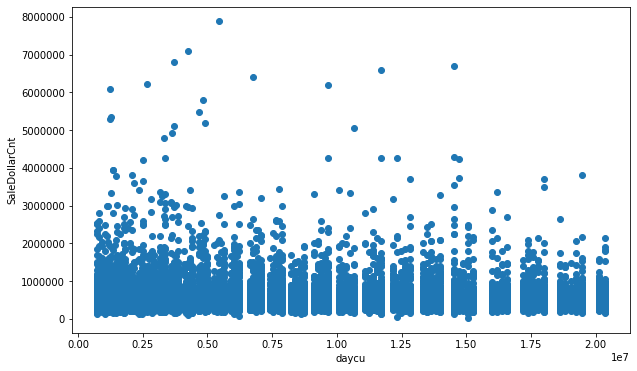

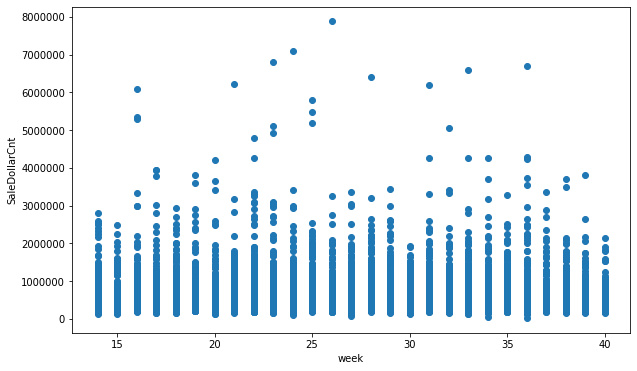

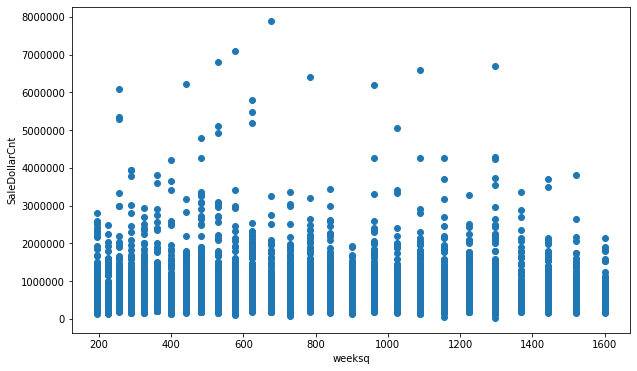

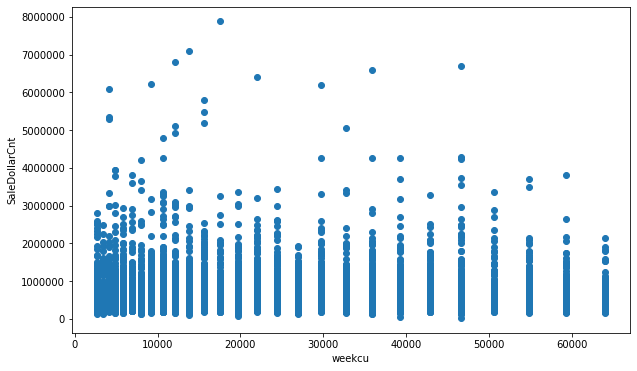

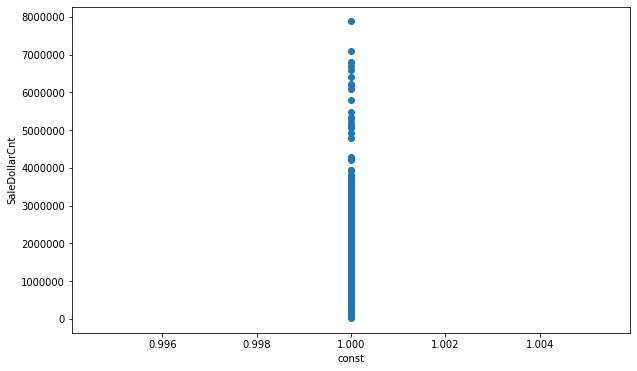

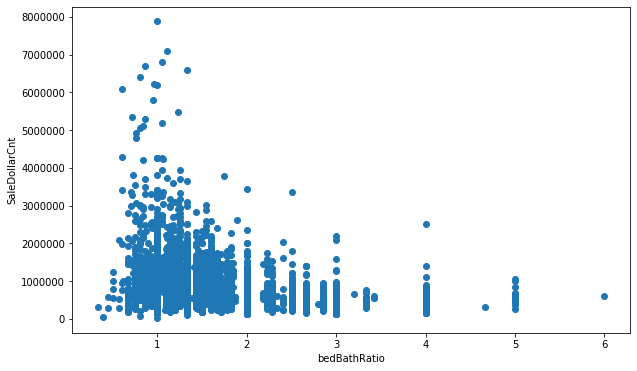

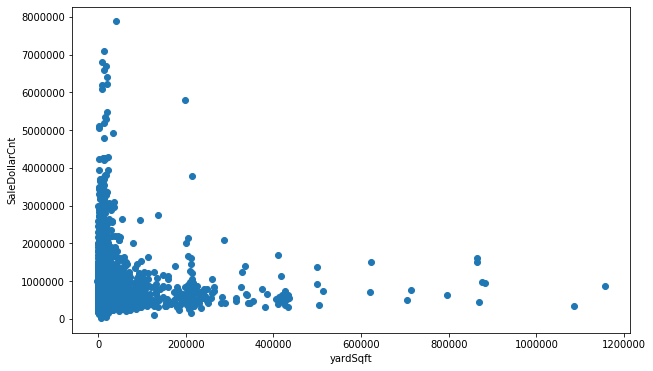

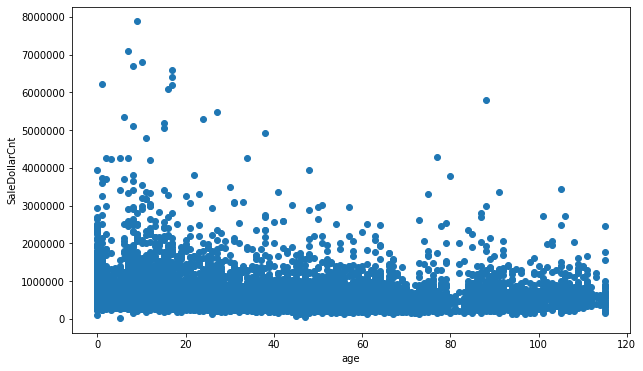

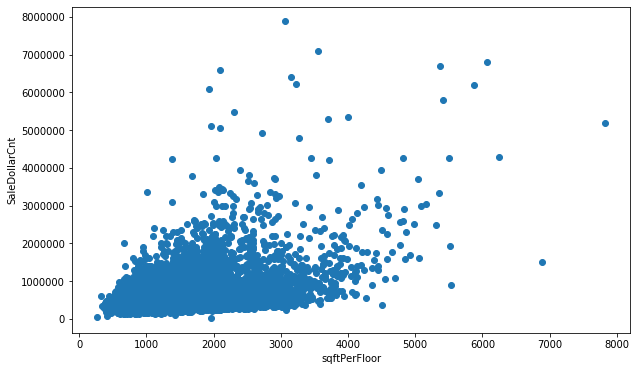

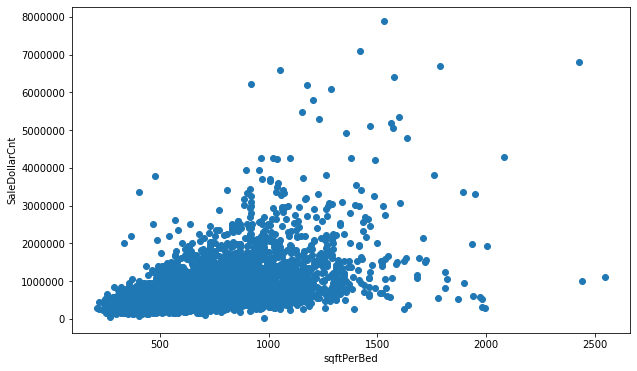

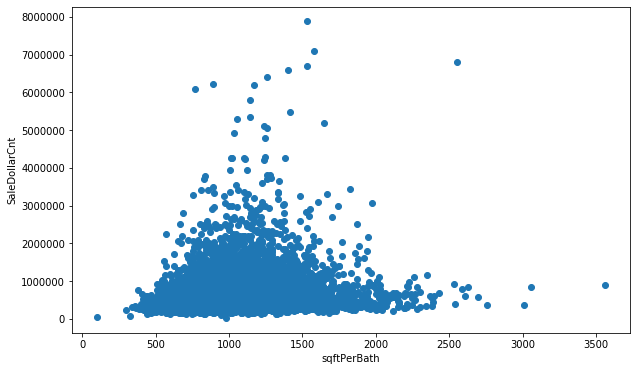

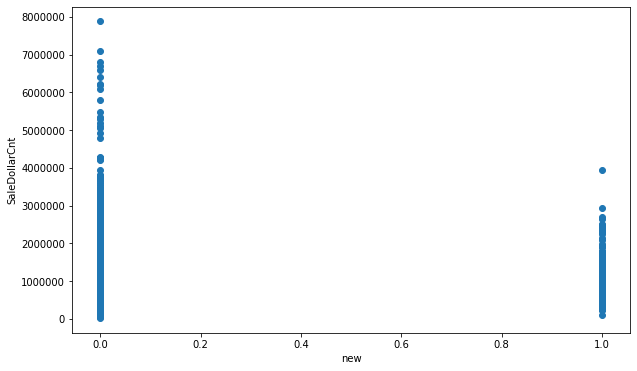

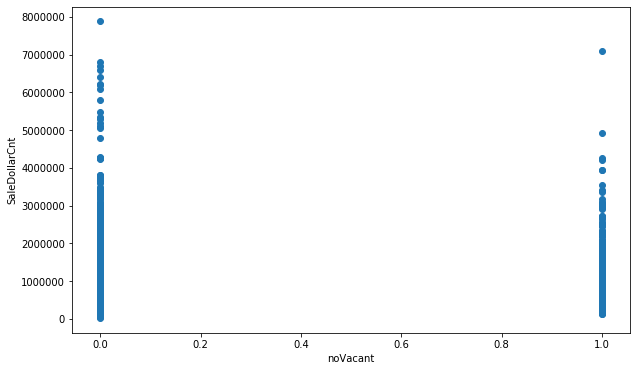

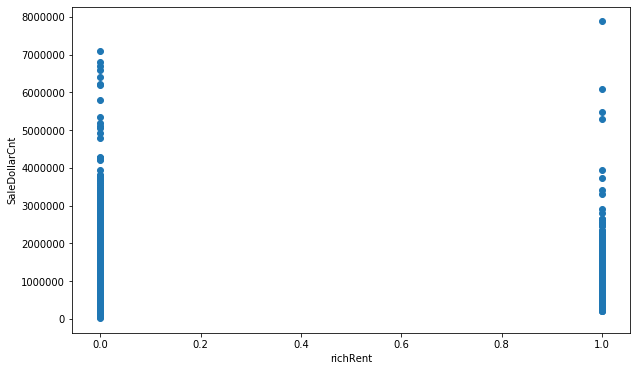

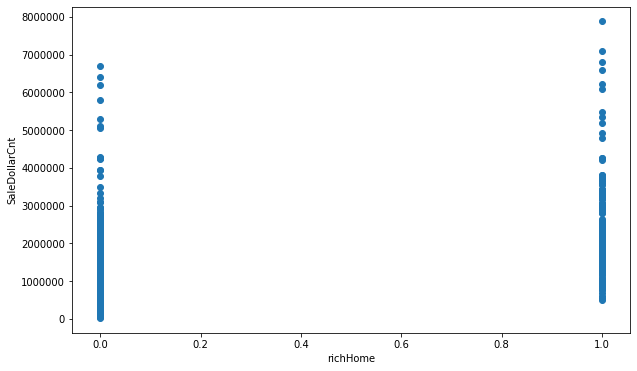

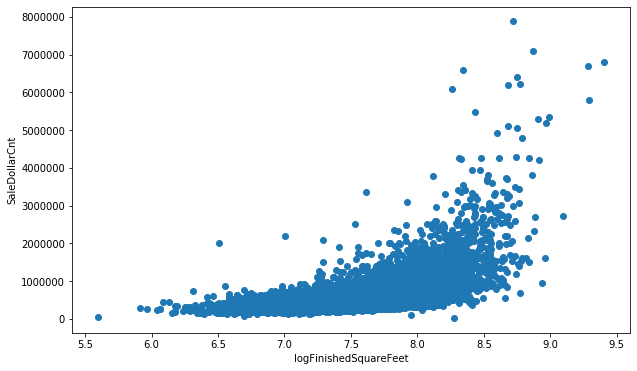

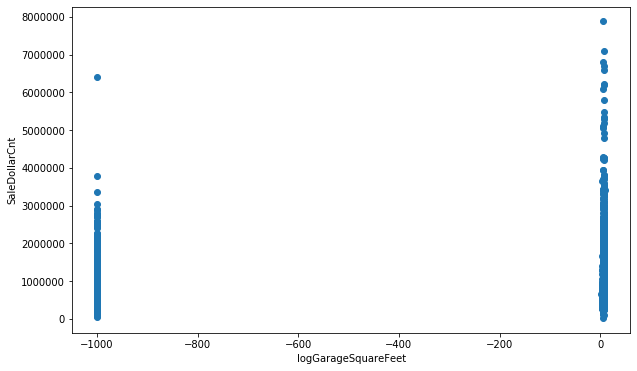

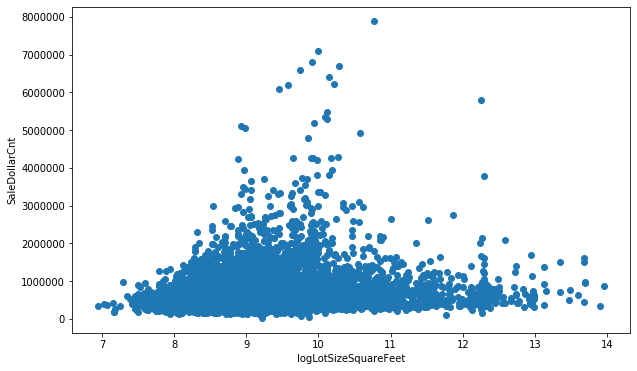

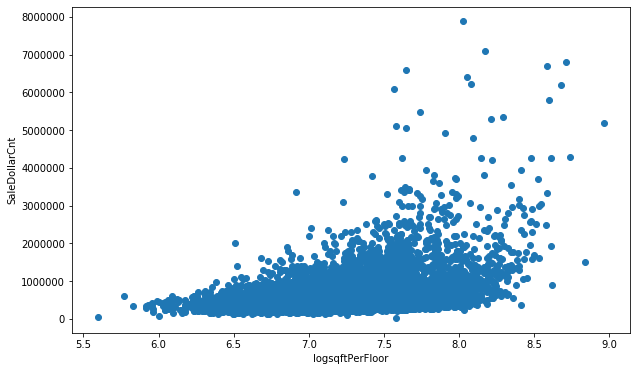

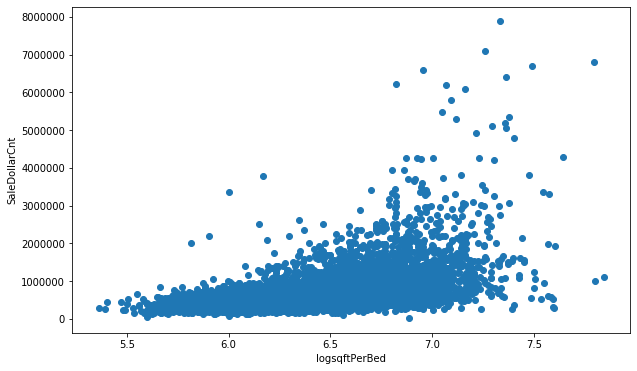

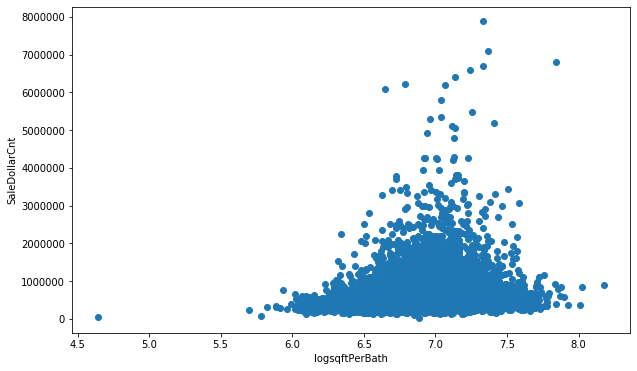

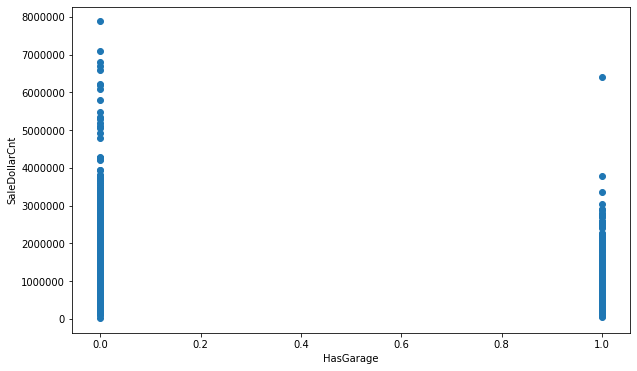

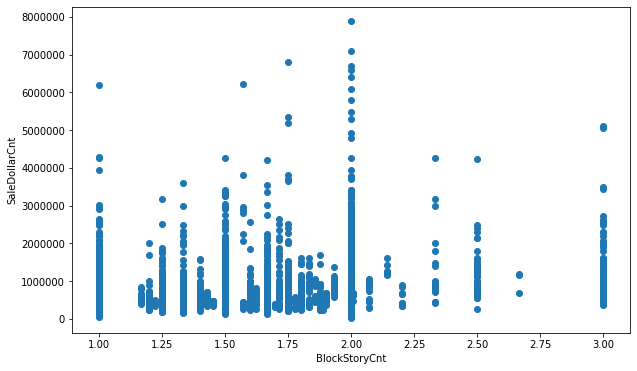

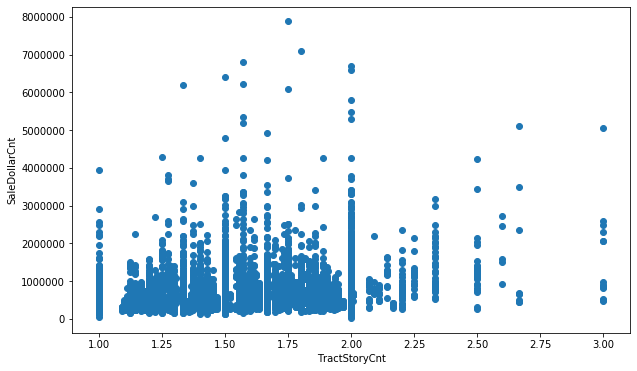

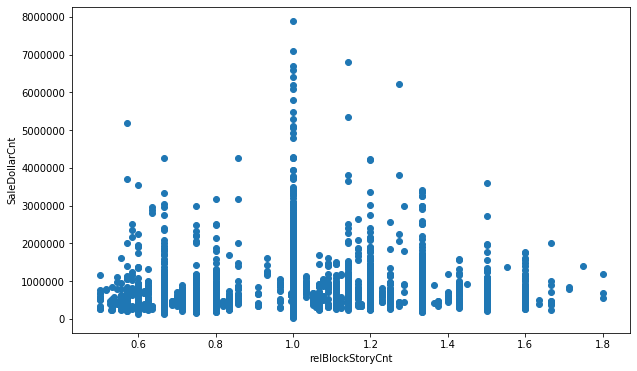

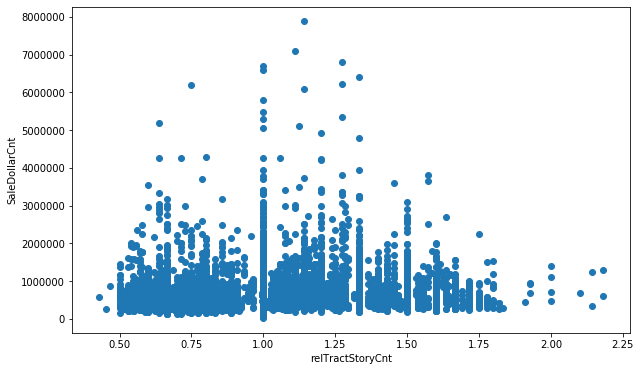

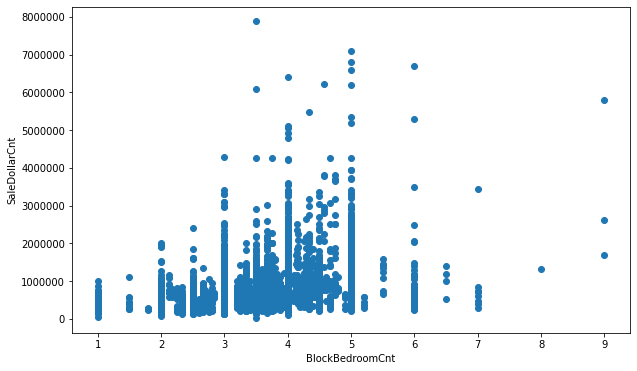

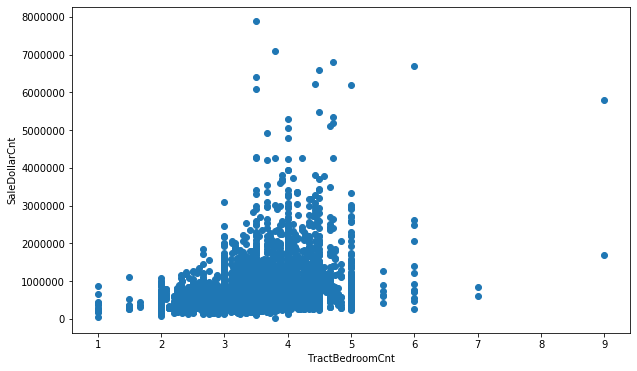

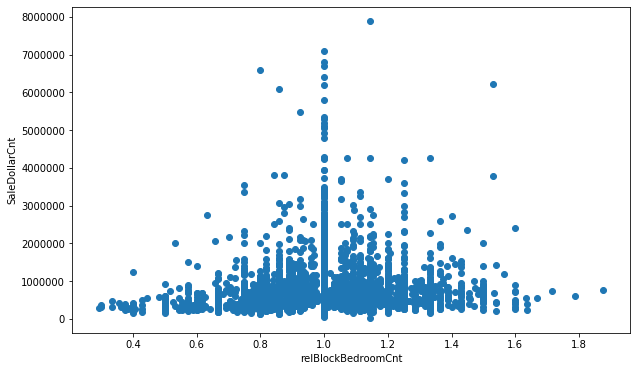

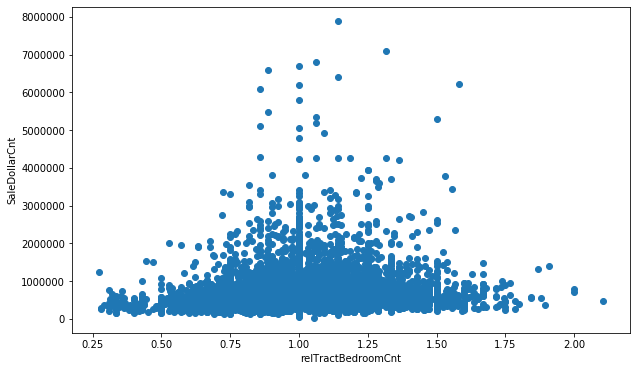

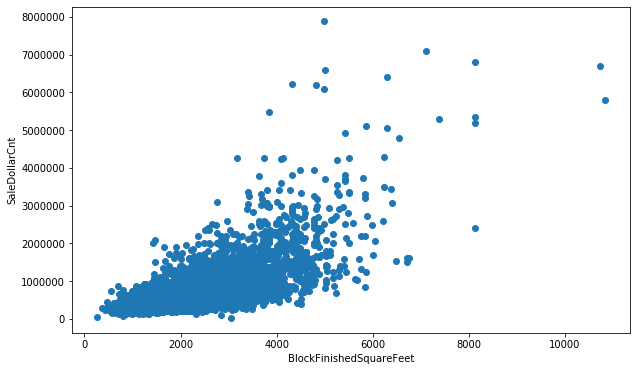

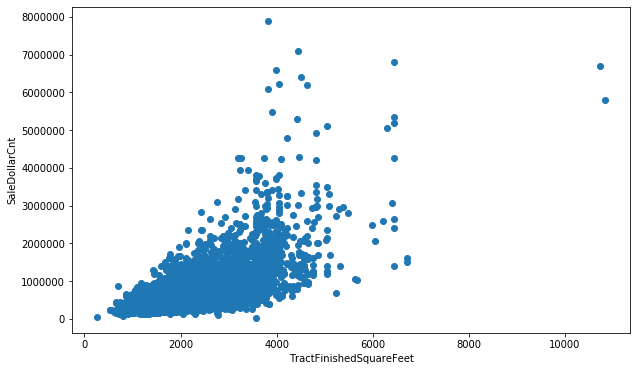

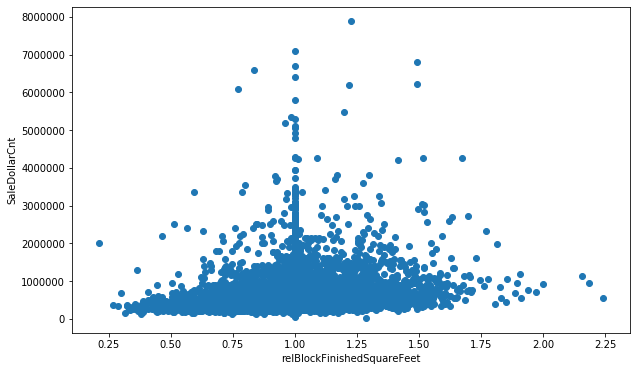

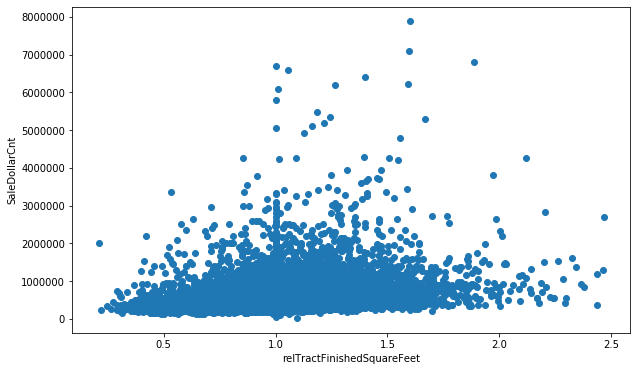

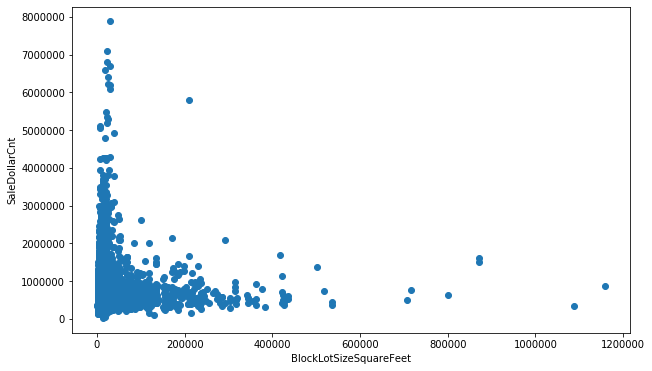

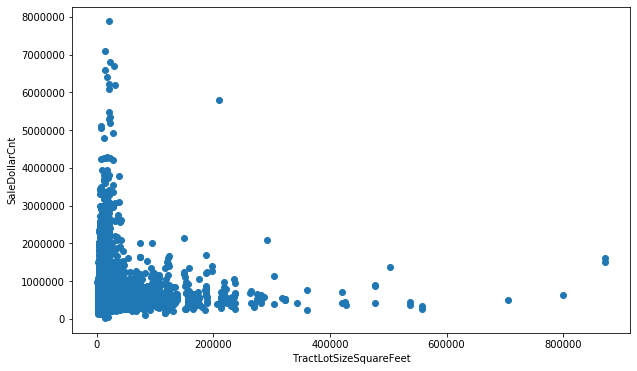

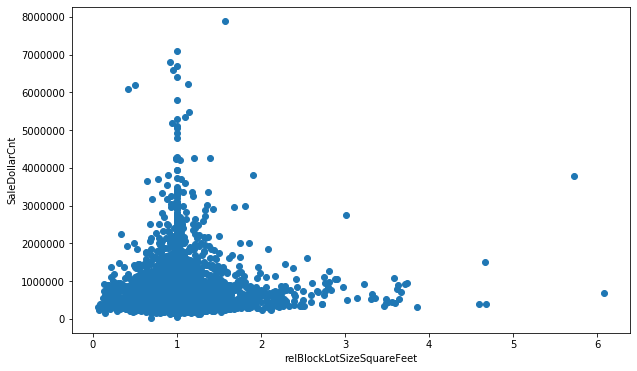

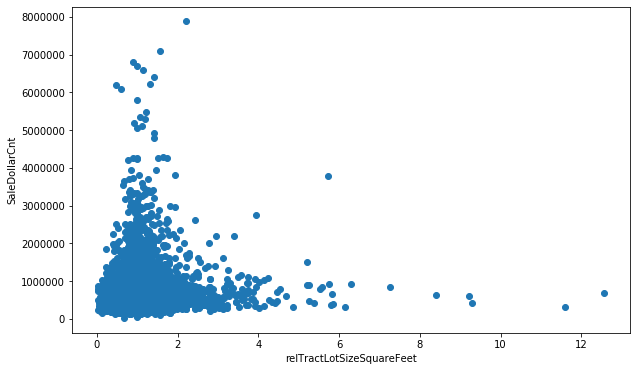

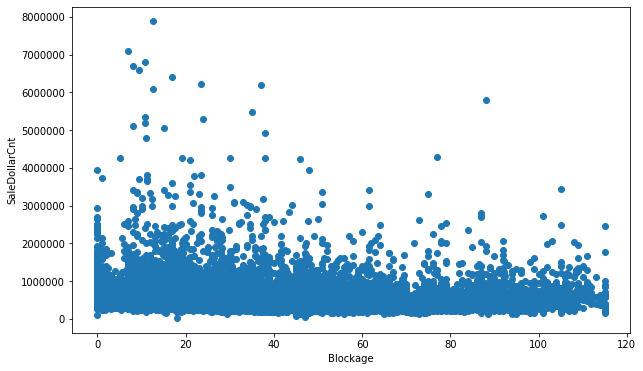

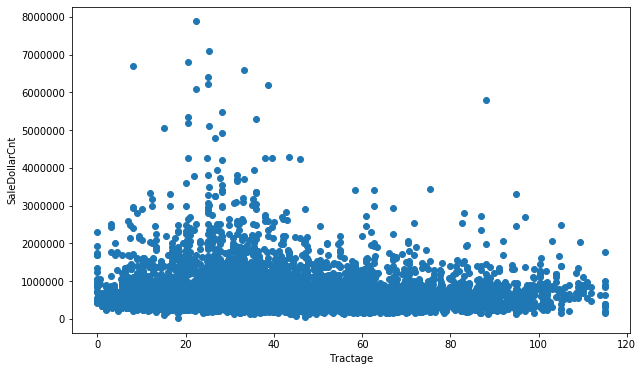

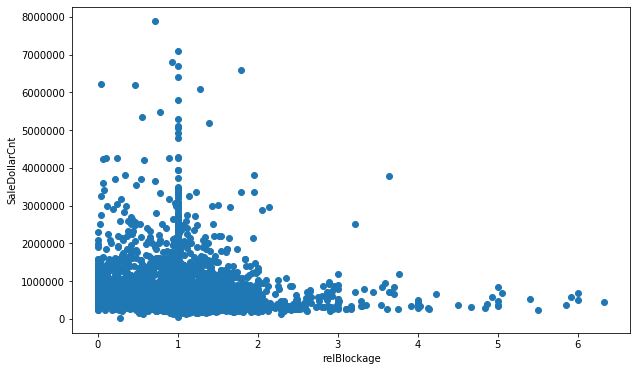

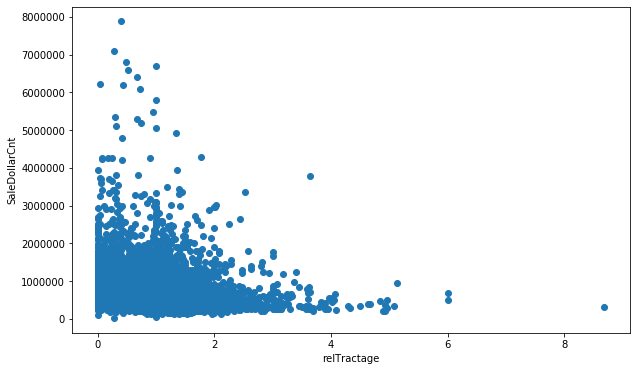

In [26]:
# # scatter plots
for var in xTrain.drop(['FIPS','tractFIPS'],axis=1):
    fig, ax = plt.subplots(figsize=(10,6))
    ax.scatter(xTrain[var], yTrain)
    ax.set_xlabel(var)
    ax.set_ylabel('SaleDollarCnt')
    plt.show()

In [5]:
#prep for pipeline and define some utility functions
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_error
from sklearn.metrics import make_scorer

def polyMaker(data,power):
    poly = PolynomialFeatures(power)
    poly_train = pd.DataFrame(poly.fit_transform(data))
    poly_train = poly_train.add_prefix('poly_').set_index(data.index)
    #concatenate the poly dataframe with original but drop the first xTrainEnc.shape[1]+1 cols because this or first ordered polynomials
    return pd.concat([data,poly_train.loc[:,'poly_'+str(data.shape[1]+1):]], axis=1)

#Important metrics: absPercError = abs(outSample-yTest)/yTest
def mape(predicted, actual):
    diff = predicted-actual
    diffRatio = diff/actual
    absPercError = abs(diffRatio)
    return 100*absPercError.median()
def aape(predicted, actual):
    diff = predicted-actual
    diffRatio = diff/actual
    absPercError = abs(diffRatio)
    return 100*absPercError.mean()

def logError(predicted, actual):
    return ln(predicted/actual)

myScore = make_scorer(logError, greater_is_better=False)

In [6]:
#build class with transformer function to use within pipeline 
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from IPython.display import clear_output

pd.options.mode.chained_assignment = None #the mapping function is fine

class myTransformerClass(BaseEstimator, TransformerMixin):
    #Class Constructor 
    def __init__(self, incluCatCols):
        self._incluCatCols = incluCatCols
        
    #Return self nothing else to do here    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        
        #generate some features relative to block- and tract-level means
        for var in ['StoryCnt','BedroomCnt','FinishedSquareFeet','LotSizeSquareFeet','age']:

            globalMean = X[var].mean()
            FIPSmean = X.groupby('FIPS')[var].mean() 
            X['Block'+var] = X['FIPS'].map(FIPSmean)
            tractFIPSmean = X.groupby('tractFIPS')[var].mean()
            X['Tract'+var] = X['tractFIPS'].map(tractFIPSmean)
            X.fillna(globalMean, inplace=True) #for unmatched FIPS fill the ratio with the global mean 
            #relative features
            X['relBlock'+var]= X[var]/X['Block'+var]
            X['relTract'+var]= X[var]/X['Tract'+var]
            X.fillna(1,inplace=True) 

        #need to drop categorical columns for preprocessing on numerical vars (polynomials and scaling)
        catCols = ['FIPS','tractFIPS','ViewType','ZoneCodeCounty']
        xNoCat = X.drop(catCols, axis=1)
        
        #add polynomial interaction terms
        xNoCatPoly = xNoCat #polyMaker(xNoCat,2)
            
        #scalar
        xScaler = StandardScaler().fit(xNoCatPoly) 
        xNoCatPolyScaled = pd.DataFrame(xScaler.transform(xNoCatPoly))
            
        #now add back our categorical data to the catboost sample
        xNew = pd.concat([X[catCols],pd.DataFrame(xNoCatPolyScaled).set_index(X.index)],axis=1)
        
        return xNew
    
def myTransform(X):        
    #generate some features relative to block- and tract-level means
    for var in ['StoryCnt','BedroomCnt','FinishedSquareFeet','LotSizeSquareFeet','age']:

        globalMean = X[var].mean()
        FIPSmean = X.groupby('FIPS')[var].mean() 
        X['Block'+var] = X['FIPS'].map(FIPSmean)
        tractFIPSmean = X.groupby('tractFIPS')[var].mean()
        X['Tract'+var] = X['tractFIPS'].map(tractFIPSmean)
        X.fillna(globalMean, inplace=True) #for unmatched FIPS fill the ratio with the global mean 
        #relative features
        X['relBlock'+var]= X[var]/X['Block'+var]
        X['relTract'+var]= X[var]/X['Tract'+var]
        X.fillna(1,inplace=True) 


    #need to drop categorical columns for preprocessing on numerical vars (polynomials and scaling)
    catCols = ['FIPS','tractFIPS','ViewType','ZoneCodeCounty']
    xNoCat = X.drop(catCols, axis=1)


    #add polynomial interaction terms
    xNoCatPolyScaled = xNoCat #polyMaker(xNoCat,2)

    #scalar
#     xScaler = StandardScaler().fit(xNoCatPoly) 
#     xNoCatPolyScaled = pd.DataFrame(xScaler.transform(xNoCatPoly))


    #now add back our categorical data to the catboost sample
    xNew = pd.concat([X[catCols],pd.DataFrame(xNoCatPolyScaled).set_index(X.index)],axis=1)

    return xNew

In [7]:
# use pipeline to run catboost and optimize over hyper parameters
import catboost
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split

# x_train, x_test, y_train, y_test = train_test_split(xTrain, yLogTrain, test_size=0.2)

# month=7
# x_trainTime = myTransform(xTrain[xTrain['TransMonth']<month])
# x_testTime = myTransform(xTrain[xTrain['TransMonth']>=month])

# y_trainTime = yLogTrain[xTrain['TransMonth']<month]
# y_testTime = yLogTrain[xTrain['TransMonth']>=month]

# x_train = myTransform(x_train)
# x_test = myTransform(x_test)

x_trainNew = myTransform(xTrain)
x_testNew = myTransform(xTest)

# #Bayesian optimization to tune hyper parameters
# model = Pipeline([('data',myTransformerClass(True)),('est',CatBoostRegressor(verbose=500, cat_features = [0,1,2,3]))])

# # #Bayesian search to tune hyperparameters
# # from skopt import BayesSearchCV
# # from sklearn.model_selection import KFold
# # from skopt import gp_minimize # Bayesian optimization using Gaussia
##from skopt.space import Real, Categorical, Integer
# # #from skopt.utils import use_named_args # decorator to convert a list of parameters to named arguments
# # import pprint
# # from time import time

# # kFold = KFold(n_splits=3, shuffle=True)

# # search_spaces = {'est__iterations': Integer(300, 500),
# #                  'est__depth': Integer(1, 9),
# #                  'est__learning_rate': Real(0.01, 1.0),
# #                  'est__random_strength': Real(1e-9, 10),
# #                  'est__bagging_temperature': Real(0.0, 1.0),
# #                  'est__border_count': Integer(1, 255),
# #                  'est__l2_leaf_reg': Integer(2, 30)}

# # bayes_search = BayesSearchCV(model,
# #                     search_spaces,
# #                     cv=kFold,
# #                     n_iter=100,
# #                     n_jobs=1,
# #                     optimizer_kwargs={'base_estimator': 'GP'})

# # bayes_search.fit(x_train, y_train)

# # best_params = bayes_search.best_params_
# # print(bayes_search.cv_results_)
# # print()
# # print(best_params)
# # print()
# # # rename params in dictionary for use in catboost
# # for param in ['est__depth','est__iterations','est__learning_rate','est__l2_leaf_reg','est__random_strength','est__bagging_temperature','est__border_count']:
# #      best_params[param[5:]] = best_params.pop(param)
# # # take best parameters and train the model
# # model = Pipeline([('data',myTransformerClass(True)),('est',CatBoostRegressor(verbose=500, cat_features = [0,1,2,3], **best_params))])
# # model.fit(x_train, y_train)

In [8]:
# best_params = {'depth': 7,
#     'iterations': 7996,
#     'learning_rate': 0.010914273830478815,
#     'l2_leaf_reg': 0,
#     'random_strength': 20.0,
#     'bagging_temperature': 0.0,
#     'border_count': 112}
# # best_params = {'bagging_temperature': 1.0, 
# #                'border_count': 116, 
# #                'depth': 7, 
# #                'iterations': 7000, 
# #                'l2_leaf_reg': 2, 
# #                'learning_rate': 0.05, 
# #                'random_strength': 20.0}

# from sklearn.metrics import mean_squared_log_error

# # create categorical feature vector for catboost encoding
# catFeatures =[]
# catCols = ['FIPS','tractFIPS','ViewType','ZoneCodeCounty']
# for cat in catCols:    
#     catFeatures.append(x_train.columns.get_loc(cat)) #output indices of categorical features

# train_pool = Pool(
#     data=x_train, 
#     label=y_train, 
#     cat_features=catFeatures
# )

# eval_pool = Pool(
#     data=x_test, 
#     label=y_test, 
#     cat_features=catFeatures
# )

# # #model.fit(x_train[y_train<np.percentile(y_train,98)],y_train[y_train<np.percentile(y_train,98)])
# model = CatBoostRegressor(verbose=500,**best_params)

# model.fit(train_pool, eval_set=eval_pool, early_stopping_rounds=500)

# inSample = np.exp(model.predict(x_train))
# outSample = np.exp(model.predict(x_test))

# #absPercError = mean(abs(outSample-yTest)/yTest)

# # The mean squared error
# print("Mean squared error (in sample): %.2f"
#     % mean_squared_error(np.exp(y_train), inSample))
# #Explained variance score: 1 is perfect prediction
# print('R-square (in sample): %.2f' % r2_score(np.exp(y_train), inSample))
# print("Mean squared error: %.2f"
#     % mean_squared_error(np.exp(y_test), outSample))
# print('R-square: %.2f' % r2_score(np.exp(y_test), outSample))
# print()
# print('Median absolute percentage error: %.2f' % mape(outSample, np.exp(y_test)))
# print('Average absolute percentage error: %.2f' % aape(outSample, np.exp(y_test)))
# print()
# print(model.get_best_iteration())

In [9]:
import random

best_params = {'depth': 7,
    'iterations': 7996,
    'learning_rate': 0.010914273830478815,
    'l2_leaf_reg': 0,
    'random_strength': 20.0,
    'bagging_temperature': 0.0,
    'border_count': 112}

# numModels = 3
# predsTest = [0.0]*numModels
# predsTrain = [0.0]*numModels
# sumTrain = [0.0]
# sumTest = [0.0]
# seed = [random.randint(0,100000),random.randint(0,100000),random.randint(0,100000)]
# for i in range(numModels):
#     model =CatBoostRegressor(verbose=500, cat_features = [0,1,2,3], **best_params, random_seed = seed[i])
#     model.fit(x_train, y_train)
#     predsTrain[i] += model.predict(x_train)
#     predsTest[i] += model.predict(x_test)
#     sumTrain +=predsTrain[i]
#     sumTest +=predsTest[i]

# avgTrain = sumTrain/numModels
# avgTest = sumTest/numModels

numModels = 5
predsTest = [0.0]*numModels
predsTrain = [0.0]*numModels
sumTrain = [0.0]
sumTest = [0.0]
seed = [random.randint(0,100000),random.randint(0,100000),random.randint(0,100000),random.randint(0,100000),random.randint(0,100000)]
for i in range(numModels):
    model =CatBoostRegressor(verbose=500, cat_features = [0,1,2,3], **best_params, random_seed = seed[i])
    model.fit(x_trainNew, yLogTrain)
    predsTrain[i] += model.predict(x_trainNew)
    predsTest[i] += model.predict(x_testNew)
    sumTrain +=predsTrain[i]
    sumTest +=predsTest[i]

avgTrain = sumTrain/numModels
avgTest = sumTest/numModels


0:	learn: 0.5276797	total: 1.04s	remaining: 2h 18m 16s
500:	learn: 0.1921892	total: 42.2s	remaining: 10m 31s
1000:	learn: 0.1697063	total: 1m 17s	remaining: 9m
1500:	learn: 0.1438484	total: 1m 53s	remaining: 8m 13s
2000:	learn: 0.1283881	total: 2m 35s	remaining: 7m 47s
2500:	learn: 0.1171612	total: 3m 36s	remaining: 7m 56s
3000:	learn: 0.1080848	total: 4m 20s	remaining: 7m 12s
3500:	learn: 0.1005229	total: 5m 19s	remaining: 6m 49s
4000:	learn: 0.0940403	total: 6m 8s	remaining: 6m 8s
4500:	learn: 0.0884487	total: 7m	remaining: 5m 26s
5000:	learn: 0.0832753	total: 7m 54s	remaining: 4m 44s
5500:	learn: 0.0787377	total: 9m 6s	remaining: 4m 8s
6000:	learn: 0.0745165	total: 9m 58s	remaining: 3m 19s
6500:	learn: 0.0707458	total: 10m 58s	remaining: 2m 31s
7000:	learn: 0.0672213	total: 11m 38s	remaining: 1m 39s
7500:	learn: 0.0639861	total: 12m 46s	remaining: 50.6s
7995:	learn: 0.0610141	total: 13m 47s	remaining: 0us
0:	learn: 0.5278871	total: 106ms	remaining: 14m 10s
500:	learn: 0.1926344	tota

In [10]:
# model =CatBoostRegressor(verbose=500, cat_features = [0,1,2,3], **best_params)
# model.fit(x_trainTime, y_trainTime)

# inSample = np.exp(model.predict(x_trainTime))
# outSample = np.exp(model.predict(x_testTime))

# #absPercError = mean(abs(outSample-yTest)/yTest)

# # The mean squared error
# print("Mean squared error (in sample): %.2f"
#     % mean_squared_error(np.exp(y_trainTime), inSample))
# #Explained variance score: 1 is perfect prediction
# print('R-square (in sample): %.2f' % r2_score(np.exp(y_trainTime), inSample))
# print("Mean squared error: %.2f"
#     % mean_squared_error(np.exp(y_testTime), outSample))
# print('R-square: %.2f' % r2_score(np.exp(y_testTime), outSample))
# print()
# print('Median absolute percentage error: %.2f' % mape(outSample, np.exp(y_testTime)))
# print('Average absolute percentage error: %.2f' % aape(outSample, np.exp(y_testTime)))

In [11]:
from sklearn.linear_model import Lasso

x_trainNew['predicted'] = avgTrain
x_testNew['predicted'] = avgTest

x_trainNew['const'] = 1
x_trainNew['day'] = x_trainNew['TransDayOfYear']
x_trainNew['daysq'] = np.power(x_trainNew['TransDayOfYear'],2)
x_trainNew['daycu'] = np.power(x_trainNew['TransDayOfYear'],3)
x_trainNew['week'] = x_trainNew['TransWeek']
x_trainNew['weeksq'] = np.power(x_trainNew['TransWeek'],2)
x_trainNew['weekcu'] = np.power(x_trainNew['TransWeek'],3)
x_trainNew = x_trainNew.loc[:,'predicted':]
x_trainNew.fillna(x_trainNew.mean(), inplace=True)

x_testNew['const'] = 1
x_testNew['day'] = x_testNew['TransDayOfYear']
x_testNew['daysq'] = np.power(x_testNew['TransDayOfYear'],2)
x_testNew['daycu'] = np.power(x_testNew['TransDayOfYear'],3)
x_testNew['week'] = x_testNew['TransWeek']
x_testNew['weeksq'] = np.power(x_testNew['TransWeek'],2)
x_testNew['weekcu'] = np.power(x_testNew['TransWeek'],3)
x_testNew = x_testNew.loc[:,'predicted':]
x_testNew.fillna(x_testNew.mean(), inplace=True)    

lasso =Lasso(0.005, max_iter=25000)
lasso.fit(x_trainNew, yLogTrain)

predTrain = lasso.predict(x_trainNew)
predTest = lasso.predict(x_testNew)

# x_trainTime['predicted'] = model.predict(x_trainTime)
# x_testTime['predicted'] = model.predict(x_testTime)


# x_trainTime['const'] = 1
# x_trainTime['day'] = x_trainTime['TransDayOfYear']
# x_trainTime['daysq'] = np.power(x_trainTime['TransDayOfYear'],2)
# x_trainTime['daycu'] = np.power(x_trainTime['TransDayOfYear'],3)
# x_trainTime['week'] = x_trainTime['TransWeek']
# x_trainTime['weeksq'] = np.power(x_trainTime['TransWeek'],2)
# x_trainTime['weekcu'] = np.power(x_trainTime['TransWeek'],3)
# x_trainTime = x_trainTime.loc[:,'predicted':]
# x_trainTime.fillna(x_trainTime.mean(), inplace=True)

# x_testTime['const'] = 1
# x_testTime['day'] = x_testTime['TransDayOfYear']
# x_testTime['daysq'] = np.power(x_testTime['TransDayOfYear'],2)
# x_testTime['daycu'] = np.power(x_testTime['TransDayOfYear'],3)
# x_testTime['week'] = x_testTime['TransWeek']
# x_testTime['weeksq'] = np.power(x_testTime['TransWeek'],2)
# x_testTime['weekcu'] = np.power(x_testTime['TransWeek'],3)
# x_testTime = x_testTime.loc[:,'predicted':]
# x_testTime.fillna(x_testTime.mean(), inplace=True)    

# lasso =Lasso(0.001, max_iter=25000)
# lasso.fit(x_trainTime, y_trainTime)

# predTrain = lasso.predict(x_trainTime)
# predTest = lasso.predict(x_testTime)

# print('Median absolute percentage error: %.2f' % mape(np.exp(predTest), np.exp(y_testTime)))
# print('Average absolute percentage error: %.2f' % aape(np.exp(predTest), np.exp(y_testTime)))



In [12]:
results = pd.DataFrame([])
results['PropertyID'] = dfTest['PropertyID']
results['SaleDollarCnt'] = np.exp(predTest)
pd.DataFrame(results).to_csv('zillowResultsWagner.csv', index=False)

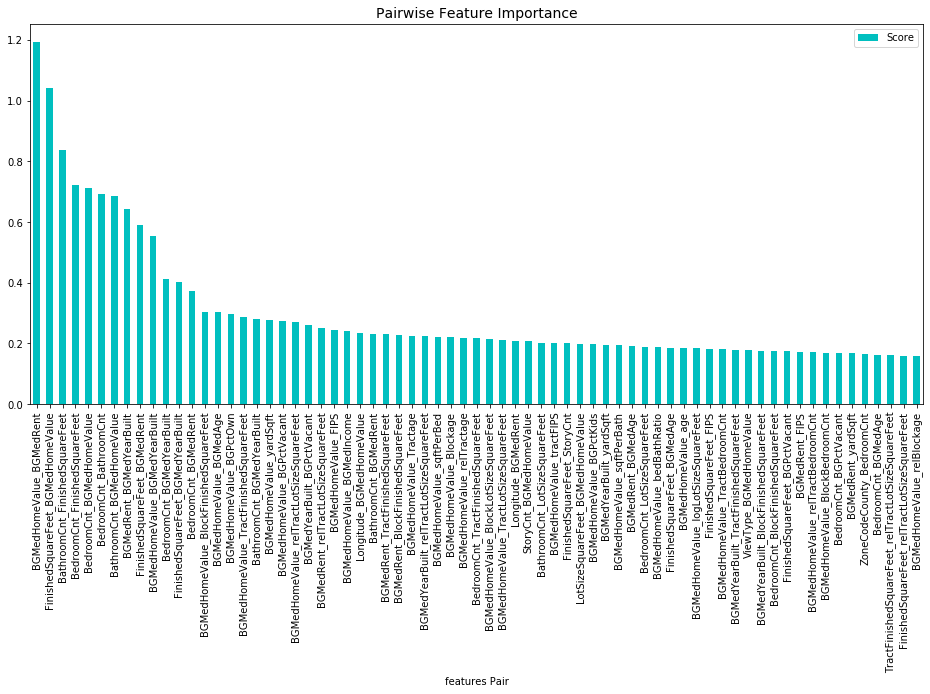

In [20]:
# x_train, x_test, y_train, y_test = train_test_split(xTrain, yLogTrain, test_size=0.2)

# x_trainNew = myTransform(x_train)
# x_testNew = myTransform(x_test)

# train_pool = Pool(
#     data=x_trainNew, 
#     label=y_train, 
#     cat_features=[0,1,2,3]
# )

# validation_pool = Pool(
#     data=x_testNew, 
#     label=y_test, 
#     cat_features=[0,1,2,3]
# )

# fi = model.get_feature_importance(train_pool, type="Interaction")

# fi_new = []
# for k,item in enumerate(fi):  
#     first = x_train.dtypes.index[fi[k][0]]
#     second = x_train.dtypes.index[fi[k][1]]
#     if first != second:
#         fi_new.append([first + "_" + second, fi[k][2]])

# feature_score = pd.DataFrame(fi_new,columns=['Feature-Pair','Score'])

feature_scoreTop = feature_score[:-2150]
feature_scoreTop = feature_scoreTop.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')
plt.rcParams["figure.figsize"] = (16,7)
ax = feature_scoreTop.plot('Feature-Pair', 'Score', kind='bar', color='c')
ax.set_title("Pairwise Feature Importance", fontsize = 14)
ax.set_xlabel("features Pair")
plt.show()



0:	learn: 0.5299821	total: 73.3ms	remaining: 9m 45s
500:	learn: 0.1945078	total: 38.1s	remaining: 9m 29s
1000:	learn: 0.1694782	total: 1m 28s	remaining: 10m 16s
1500:	learn: 0.1404685	total: 2m 15s	remaining: 9m 45s
2000:	learn: 0.1243614	total: 2m 56s	remaining: 8m 48s
2500:	learn: 0.1124809	total: 3m 52s	remaining: 8m 31s
3000:	learn: 0.1029462	total: 4m 58s	remaining: 8m 17s
3500:	learn: 0.0948581	total: 5m 51s	remaining: 7m 30s
4000:	learn: 0.0878924	total: 6m 44s	remaining: 6m 43s
4500:	learn: 0.0816749	total: 7m 35s	remaining: 5m 53s
5000:	learn: 0.0761545	total: 8m 42s	remaining: 5m 12s
5500:	learn: 0.0711985	total: 9m 38s	remaining: 4m 22s
6000:	learn: 0.0667627	total: 10m 27s	remaining: 3m 28s
6500:	learn: 0.0627542	total: 11m 18s	remaining: 2m 36s
7000:	learn: 0.0591074	total: 12m 15s	remaining: 1m 44s
7500:	learn: 0.0556946	total: 13m 4s	remaining: 51.8s
7995:	learn: 0.0526534	total: 13m 58s	remaining: 0us


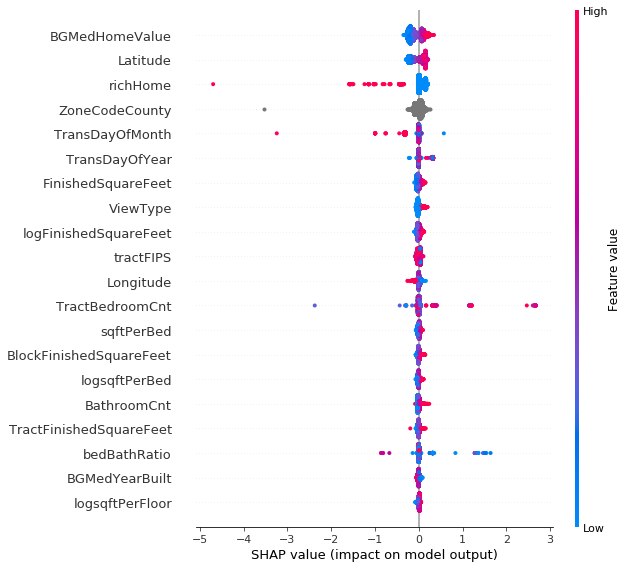

In [23]:
import shap

model =CatBoostRegressor(verbose=500, cat_features = [0,1,2,3], **best_params, random_seed = seed[i])
model.fit(x_trainNew, y_train)

#shap_values = explainer.shap_values(x_trainNew)
shap_values = model.get_feature_importance(
    train_pool,
    'ShapValues'
)
expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]

shap.summary_plot(shap_values, x_trainNew)